In [1]:

# import matplotlib
# matplotlib.use('TkAgg')
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import os
import glob
import fnmatch
from collections import namedtuple, OrderedDict
import scipy.io as sio
from scipy import interpolate, signal
from pyproj import Proj,transform
import sys
sys.path.append('/ocean/ssahu/CANYONS/wcvi/grid/')
from grid_alignment import calculate_initial_compass_bearing as cibc
from bathy_common import *
from matplotlib import path
import xarray as xr
import pandas as pd
import scipy.io as sio
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.gridspec as gridspec
from dateutil.parser import parse
from salishsea_tools import geo_tools, viz_tools, tidetools, nc_tools
import gsw
%matplotlib inline

/home/ssahu/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [2]:
path_to_save ='/data/ssahu/NEP36_Extracted_Months/' #'/home/ssahu/saurav/'


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry'][:]

zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht']

lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]

z0 = np.ma.masked_values(Z, 0)

y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))

In [3]:
def U_timeseries_at_WCVI_locations(grid_U):
    
    u_vel = grid_U.variables['vozocrtx'][0,:, y_wcvi_slice[:], x_wcvi_slice[:]]

    
    vector_u = namedtuple('vector_u', 'u_vel')

    return vector_u(u_vel)


def V_timeseries_at_WCVI_locations(grid_V):
    
    v_vel = grid_V.variables['vomecrty'][0,:, y_wcvi_slice[:], x_wcvi_slice[:]]

    
    vector_v = namedtuple('vector_v', 'v_vel')

    return vector_v(v_vel)

In [4]:
from __future__ import division
import glob
import os
import fnmatch
from collections import namedtuple, OrderedDict

import os


u_aug = np.empty((31,50,y_wcvi_slice.shape[0],x_wcvi_slice.shape[0]))
v_aug = np.empty((31,50,y_wcvi_slice.shape[0],x_wcvi_slice.shape[0]))



i = 0

for file in sorted(glob.glob('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_201508*grid_U.nc')):
    vector_u = U_timeseries_at_WCVI_locations(nc.Dataset(file))
    u_aug[i,...] = vector_u[0]
    i = i+1

j = 0
for file in sorted(glob.glob('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_201508*grid_V.nc')):
    vector_v = V_timeseries_at_WCVI_locations(nc.Dataset(file))
    v_aug[j,...] = vector_v[0]
    j = j+1
    
    


u_jun = np.empty((30,50,y_wcvi_slice.shape[0],x_wcvi_slice.shape[0]))
v_jun = np.empty((30,50,y_wcvi_slice.shape[0],x_wcvi_slice.shape[0]))



i = 0

for file in sorted(glob.glob('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_201506*grid_U.nc')):
    vector_u = U_timeseries_at_WCVI_locations(nc.Dataset(file))
    u_jun[i,...] = vector_u[0]
    i = i+1

j = 0
for file in sorted(glob.glob('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_201506*grid_V.nc')):
    vector_v = V_timeseries_at_WCVI_locations(nc.Dataset(file))
    v_jun[j,...] = vector_v[0]
    j = j+1


u_july = np.empty((31,50,y_wcvi_slice.shape[0],x_wcvi_slice.shape[0]))
v_july = np.empty((31,50,y_wcvi_slice.shape[0],x_wcvi_slice.shape[0]))



i = 0

for file in sorted(glob.glob('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_201507*grid_U.nc')):
    vector_u = U_timeseries_at_WCVI_locations(nc.Dataset(file))
    u_july[i,...] = vector_u[0]
    i = i+1

j = 0
for file in sorted(glob.glob('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_201507*grid_V.nc')):
    vector_v = V_timeseries_at_WCVI_locations(nc.Dataset(file))
    v_july[j,...] = vector_v[0]
    j = j+1
    
u_sep = np.empty((30,50,y_wcvi_slice.shape[0],x_wcvi_slice.shape[0]))
v_sep = np.empty((30,50,y_wcvi_slice.shape[0],x_wcvi_slice.shape[0]))


i = 0

for file in sorted(glob.glob('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_201509*grid_U.nc')):
    vector_u = U_timeseries_at_WCVI_locations(nc.Dataset(file))
    u_sep[i,...] = vector_u[0]
    i = i+1

j = 0
for file in sorted(glob.glob('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_201509*grid_V.nc')):
    vector_v = V_timeseries_at_WCVI_locations(nc.Dataset(file))
    v_sep[j,...] = vector_v[0]
    j = j+1


In [5]:
u_total = np.concatenate((u_jun, u_july, u_aug, u_sep), axis = 0)
v_total = np.concatenate((v_jun, v_july, v_aug, v_sep), axis = 0)

In [6]:
u_tzyx = np.empty_like(u_total)
v_tzyx = np.empty_like(v_total)

u_tzyx, v_tzyx = viz_tools.unstagger(u_total, v_total)

In [7]:


mag_vel = np.sqrt(np.multiply(u_tzyx,u_tzyx), np.multiply(v_tzyx,v_tzyx))


ang_vel = np.degrees(np.arctan2(v_tzyx, u_tzyx))

In [13]:
lon_slice = lon[180:350,480:650]
lat_slice = lat[180:350,480:650]

lon_slice = lon_slice[1:,1:]
lat_slice = lat_slice[1:, 1:]

lon_A1 = -126.20433
lat_A1 = 48.52958

j, i = geo_tools.find_closest_model_point(lon_A1,lat_A1,\
                                          lon_slice,lat_slice,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 


print(j,i)


lon_W01 = -124.82500
lat_W01 = 48.31500

y, x = geo_tools.find_closest_model_point(lon_W01,lat_W01,\
                                          lon_slice,lat_slice,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})      

print(y, x)

88 91
78 142


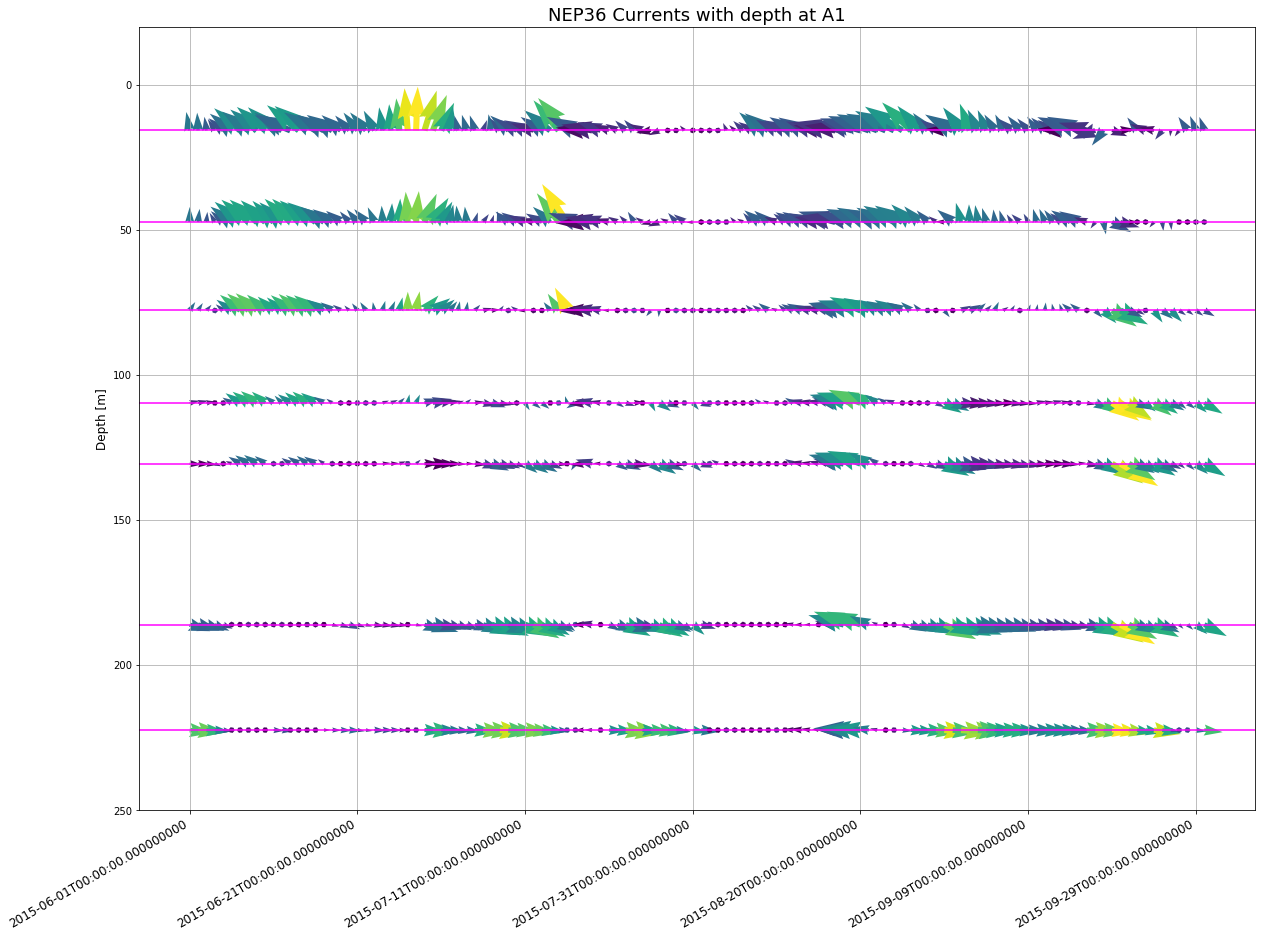

In [24]:
step = 1

# u_84 = vel_east_84[:4320]
# v_84 = vel_north_84[:4320]
# mag_84 = np.sqrt(u_84**2,v_84**2)

time_axis_quiver = np.arange(0,122,step)




# time_axis = datetime_A1[:2420]
# time_tick = time_axis[::step]
# time_axis_quiver = np.arange(0,2420,step)



fig, ax = plt.subplots(1, 1, figsize=(20,16))

ax.quiver(time_axis_quiver, zlevels[10], v_tzyx[:,10,j,i], u_tzyx[:,10,j,i], mag_vel[:,10,j,i], angles='uv', scale_units='inches', scale=0.5)
ax.axhline(y=zlevels[10], color='magenta', label = '{0} m'.format(zlevels[10]))

ax.quiver(time_axis_quiver, zlevels[17], v_tzyx[:,17,j,i], u_tzyx[:,17,j,i], mag_vel[:,17,j,i], angles='uv', scale_units='inches', scale=0.5)
ax.axhline(y=zlevels[17], color='magenta', label = '{0} m'.format(zlevels[17]))

ax.quiver(time_axis_quiver, zlevels[20], v_tzyx[:,20,j,i], u_tzyx[:,20,j,i], mag_vel[:,20,j,i], angles='uv', scale_units='inches', scale=0.5)
ax.axhline(y=zlevels[20], color='magenta', label = '{0} m'.format(zlevels[20]))

ax.quiver(time_axis_quiver, zlevels[22], v_tzyx[:,22,j,i], u_tzyx[:,22,j,i], mag_vel[:,22,j,i], angles='uv', scale_units='inches', scale=0.5)
ax.axhline(y=zlevels[22], color='magenta', label = '{0} m'.format(zlevels[22]))

ax.quiver(time_axis_quiver, zlevels[23], v_tzyx[:,23,j,i], u_tzyx[:,23,j,i], mag_vel[:,23,j,i], angles='uv', scale_units='inches', scale=0.5)
ax.axhline(y=zlevels[23], color='magenta', label = '{0} m'.format(zlevels[23]))

ax.quiver(time_axis_quiver, zlevels[25], v_tzyx[:,25,j,i], u_tzyx[:,25,j,i], mag_vel[:,25,j,i], angles='uv', scale_units='inches', scale=0.5)
ax.axhline(y=zlevels[25], color='magenta', label = '{0} m'.format(zlevels[25]))

ax.quiver(time_axis_quiver, zlevels[26], v_tzyx[:,26,j,i], u_tzyx[:,27,j,i], mag_vel[:,26,j,i], angles='uv', scale_units='inches', scale=0.5)
ax.axhline(y=zlevels[26], color='magenta', label = '{0} m'.format(zlevels[26]))


# ax.quiver(time_axis_quiver, 84.44, vel_east_84[::step], vel_north_84[::step], mag_84[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=84.44, color='magenta', label = '84 m')

# ax.quiver(time_axis_quiver, 148.44, vel_east_148[::step], vel_north_148[::step], mag_148[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=148.44, color='red', label = '148 m')

# ax.quiver(time_axis_quiver, 196.44, vel_east_196[::step], vel_north_196[::step], mag_196[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=196.44, color='orangered', label = '196 m')

# ax.quiver(time_axis_quiver, 260.44, vel_east_260[::step], vel_north_260[::step], mag_260[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=260.44, color='cyan', label = '196 m')

# ax.quiver(time_axis_quiver, 228.44, vel_east_228[::step], vel_north_228[::step], mag_228[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=228.44, color='purple', label = '228 m')

ax.set_ylabel('Depth [m]', fontsize =12)
plt.xticks(time_axis_quiver[::20], mydates[::20], fontsize =12)
# ax.format_xdata = DateFormatter('%Y-%m-%d')
fig.autofmt_xdate()
ax.set_ylim(-20, 250)
ax.invert_yaxis()
ax.set_title('NEP36 Currents with depth at A1', fontsize =18)
# legend = ax.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
ax.grid() 
plt.show()

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/quiver.py:664: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/quiver.py:664: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/quiver.py:720: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/quiver.py:734: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minlength


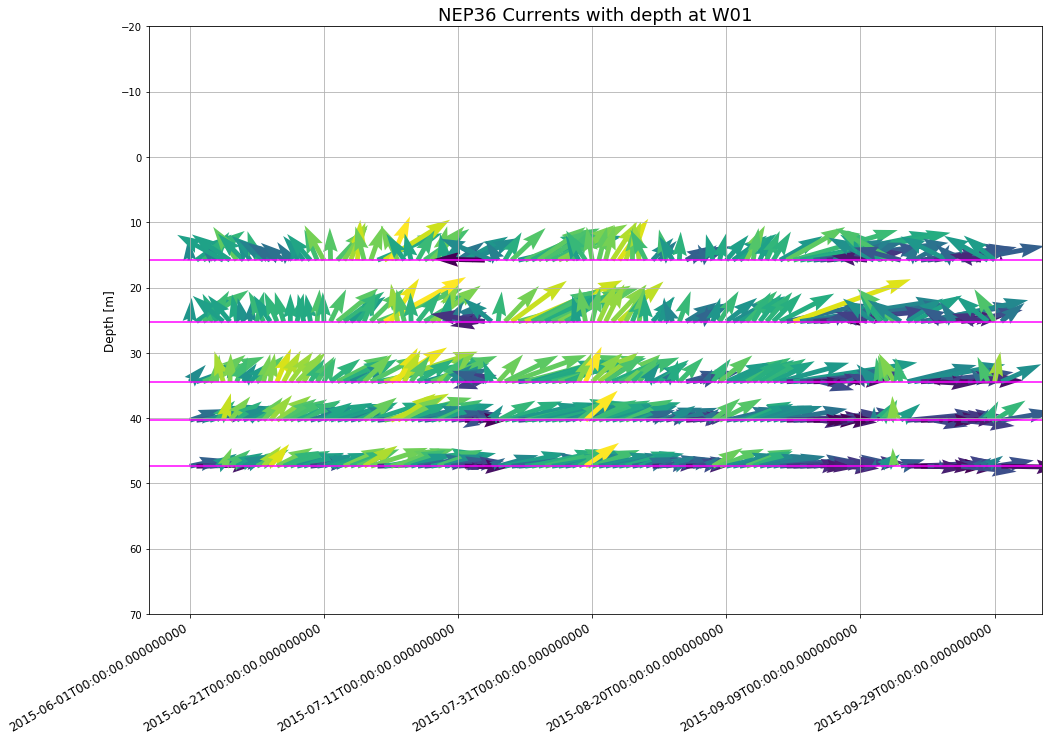

In [21]:
step = 1

# u_84 = vel_east_84[:4320]
# v_84 = vel_north_84[:4320]
# mag_84 = np.sqrt(u_84**2,v_84**2)

time_axis_quiver = np.arange(0,122,step)



# time_axis = datetime_A1[:2420]
# time_tick = time_axis[::step]
# time_axis_quiver = np.arange(0,2420,step)



fig, ax = plt.subplots(1, 1, figsize=(16,12))

ax.quiver(time_axis_quiver, zlevels[10], v_tzyx[:,10,y,x], u_tzyx[:,10,y,x], mag_vel[:,10,y,x], angles='uv', scale_units='inches')
ax.axhline(y=zlevels[10], color='magenta', label = '{0} m'.format(zlevels[10]))

ax.quiver(time_axis_quiver, zlevels[17], v_tzyx[:,17,y,x], u_tzyx[:,17,y,x], mag_vel[:,17,y,x], angles='uv', scale_units='inches')
ax.axhline(y=zlevels[17], color='magenta', label = '{0} m'.format(zlevels[17]))

ax.quiver(time_axis_quiver, zlevels[13], v_tzyx[:,13,y,x], u_tzyx[:,13,y,x], mag_vel[:,13,y,x], angles='uv', scale_units='inches')
ax.axhline(y=zlevels[13], color='magenta', label = '{0} m'.format(zlevels[13]))

ax.quiver(time_axis_quiver, zlevels[15], v_tzyx[:,15,y,x], u_tzyx[:,15,y,x], mag_vel[:,15,y,x], angles='uv', scale_units='inches')
ax.axhline(y=zlevels[15], color='magenta', label = '{0} m'.format(zlevels[15]))

ax.quiver(time_axis_quiver, zlevels[16], v_tzyx[:,16,y,x], u_tzyx[:,16,y,x], mag_vel[:,16,y,x], angles='uv', scale_units='inches')
ax.axhline(y=zlevels[16], color='magenta', label = '{0} m'.format(zlevels[16]))

ax.quiver(time_axis_quiver, zlevels[25], v_tzyx[:,25,y,x], u_tzyx[:,25,y,x], mag_vel[:,25,y,x], angles='uv', scale_units='inches')
ax.axhline(y=zlevels[25], color='magenta', label = '{0} m'.format(zlevels[25]))

ax.quiver(time_axis_quiver, zlevels[26], v_tzyx[:,26,y,x], u_tzyx[:,27,y,x], mag_vel[:,26,y,x], angles='uv', scale_units='inches')
ax.axhline(y=zlevels[26], color='magenta', label = '{0} m'.format(zlevels[26]))


# ax.quiver(time_axis_quiver, 84.44, vel_east_84[::step], vel_north_84[::step], mag_84[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=84.44, color='magenta', label = '84 m')

# ax.quiver(time_axis_quiver, 148.44, vel_east_148[::step], vel_north_148[::step], mag_148[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=148.44, color='red', label = '148 m')

# ax.quiver(time_axis_quiver, 196.44, vel_east_196[::step], vel_north_196[::step], mag_196[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=196.44, color='orangered', label = '196 m')

# ax.quiver(time_axis_quiver, 260.44, vel_east_260[::step], vel_north_260[::step], mag_260[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=260.44, color='cyan', label = '196 m')

# ax.quiver(time_axis_quiver, 228.44, vel_east_228[::step], vel_north_228[::step], mag_228[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=228.44, color='purple', label = '228 m')

ax.set_ylabel('Depth [m]', fontsize =12)
plt.xticks(time_axis_quiver[::20], mydates[::20], fontsize =12)
# ax.format_xdata = DateFormatter('%Y-%m-%d')
fig.autofmt_xdate()
ax.set_ylim(-20, 70)
ax.invert_yaxis()
ax.set_title('NEP36 Currents with depth at W01', fontsize =18)
# legend = ax.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
ax.grid() 
plt.show()

In [66]:


fname_coord = "/data/mdunphy/NEP036-N30-OUT/INV/coordinates.nc"

with nc.Dataset(fname_coord, 'r') as cnc:
    glamt = cnc.variables['glamt'][180:350,480:650]; gphit = cnc.variables['gphit'][180:350,480:650]
    glamu = cnc.variables['glamu'][180:350,480:650]; gphiu = cnc.variables['gphiu'][180:350,480:650]
    glamv = cnc.variables['glamv'][180:350,480:650]; gphiv = cnc.variables['gphiv'][180:350,480:650]
    
# First point
lonA = glamu[:,0:-1]
latA = gphiu[:,0:-1]
# Second point
lonB = glamu[:,1:]
latB = gphiu[:,1:]

In [67]:
bearing_ = np.empty_like(glamt)


bearing = cibc((latA,lonA),(latB,lonB))



bearing = 90 - bearing

bearing = bearing[1:,:]



In [68]:
for i in np.arange(ang_vel.shape[0]):
    for j in np.arange(ang_vel.shape[1]):
        angle_unrotated = ang_vel[i,j,...] + bearing[...];
        

In [69]:
u_unrotated = np.empty_like(mag_vel)
v_unrotated = np.empty_like(mag_vel)



u_unrotated[:] = mag_vel[:]*np.cos(np.radians(angle_unrotated[:]))

v_unrotated[:] = mag_vel[:]*np.sin(np.radians(angle_unrotated[:]))



88 91


In [11]:
date1 = '2015-06-01'
date2 = '2015-09-30'
mydates = np.array(pd.date_range(date1, date2))

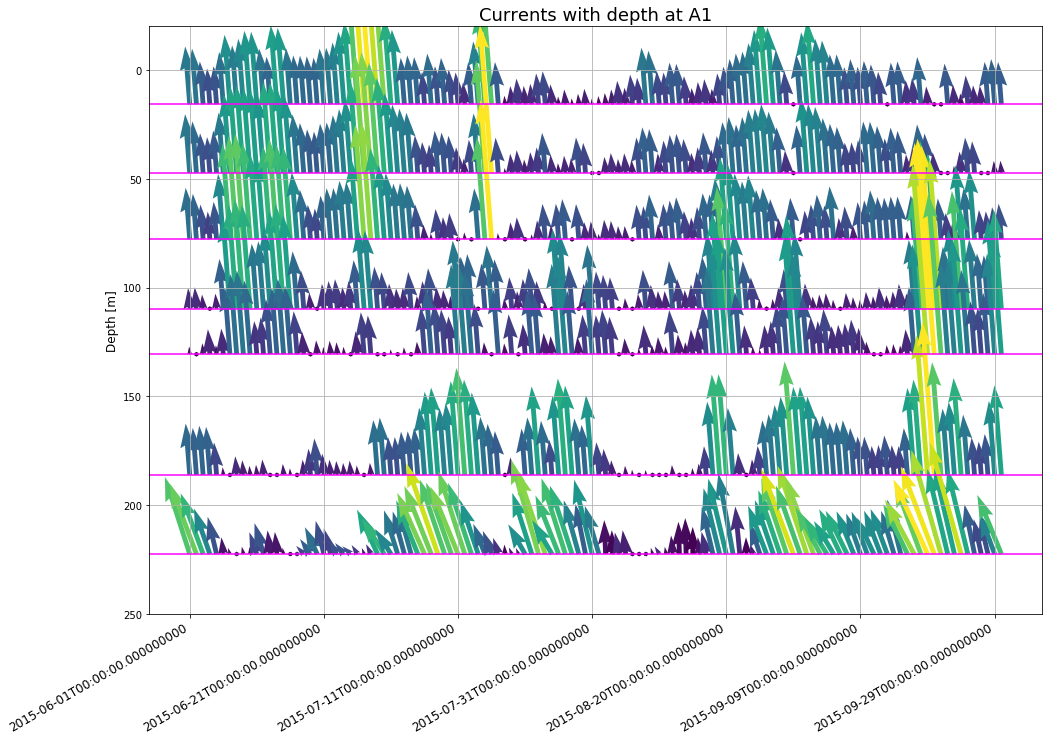

In [55]:
step = 1

# u_84 = vel_east_84[:4320]
# v_84 = vel_north_84[:4320]
# mag_84 = np.sqrt(u_84**2,v_84**2)

time_axis_quiver = np.arange(0,122,step)



# time_axis = datetime_A1[:2420]
# time_tick = time_axis[::step]
# time_axis_quiver = np.arange(0,2420,step)



fig, ax = plt.subplots(1, 1, figsize=(16,12))

ax.quiver(time_axis_quiver, zlevels[10], v_unrotated[:,10,j,i], u_unrotated[:,10,j,i], mag_vel[:,10,j,i], angles='uv', scale_units='inches')
ax.axhline(y=zlevels[10], color='magenta', label = '{0} m'.format(zlevels[10]))

ax.quiver(time_axis_quiver, zlevels[17], v_unrotated[:,17,j,i], u_unrotated[:,17,j,i], mag_vel[:,17,j,i], angles='uv', scale_units='inches')
ax.axhline(y=zlevels[17], color='magenta', label = '{0} m'.format(zlevels[17]))

ax.quiver(time_axis_quiver, zlevels[20], v_unrotated[:,20,j,i], u_unrotated[:,20,j,i], mag_vel[:,20,j,i], angles='uv', scale_units='inches')
ax.axhline(y=zlevels[20], color='magenta', label = '{0} m'.format(zlevels[20]))

ax.quiver(time_axis_quiver, zlevels[22], v_unrotated[:,22,j,i], u_unrotated[:,22,j,i], mag_vel[:,22,j,i], angles='uv', scale_units='inches')
ax.axhline(y=zlevels[22], color='magenta', label = '{0} m'.format(zlevels[22]))

ax.quiver(time_axis_quiver, zlevels[23], v_unrotated[:,23,j,i], u_unrotated[:,23,j,i], mag_vel[:,23,j,i], angles='uv', scale_units='inches')
ax.axhline(y=zlevels[23], color='magenta', label = '{0} m'.format(zlevels[23]))

ax.quiver(time_axis_quiver, zlevels[25], v_unrotated[:,25,j,i], u_unrotated[:,25,j,i], mag_vel[:,25,j,i], angles='uv', scale_units='inches')
ax.axhline(y=zlevels[25], color='magenta', label = '{0} m'.format(zlevels[25]))

ax.quiver(time_axis_quiver, zlevels[26], v_unrotated[:,26,j,i], u_unrotated[:,27,j,i], mag_vel[:,26,j,i], angles='uv', scale_units='inches')
ax.axhline(y=zlevels[26], color='magenta', label = '{0} m'.format(zlevels[26]))


# ax.quiver(time_axis_quiver, 84.44, vel_east_84[::step], vel_north_84[::step], mag_84[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=84.44, color='magenta', label = '84 m')

# ax.quiver(time_axis_quiver, 148.44, vel_east_148[::step], vel_north_148[::step], mag_148[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=148.44, color='red', label = '148 m')

# ax.quiver(time_axis_quiver, 196.44, vel_east_196[::step], vel_north_196[::step], mag_196[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=196.44, color='orangered', label = '196 m')

# ax.quiver(time_axis_quiver, 260.44, vel_east_260[::step], vel_north_260[::step], mag_260[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=260.44, color='cyan', label = '196 m')

# ax.quiver(time_axis_quiver, 228.44, vel_east_228[::step], vel_north_228[::step], mag_228[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=228.44, color='purple', label = '228 m')

ax.set_ylabel('Depth [m]', fontsize =12)
plt.xticks(time_axis_quiver[::20], mydates[::20], fontsize =12)
# ax.format_xdata = DateFormatter('%Y-%m-%d')
fig.autofmt_xdate()
ax.set_ylim(-20, 250)
ax.invert_yaxis()
ax.set_title('Currents with depth at A1', fontsize =18)
# legend = ax.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
ax.grid() 
plt.show()

In [24]:
mask = nc.Dataset("/data/mdunphy/NEP036-N30-OUT/INV/mesh_mask.nc")

In [37]:
v_mask = mask.variables['vmask'][0,:30,y_wcvi_slice[:],x_wcvi_slice[:]]
t_mask = mask.variables['tmask'][0,:30,y_wcvi_slice[:],x_wcvi_slice[:]]

In [26]:
v_mask.shape

(30, 170, 170)

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


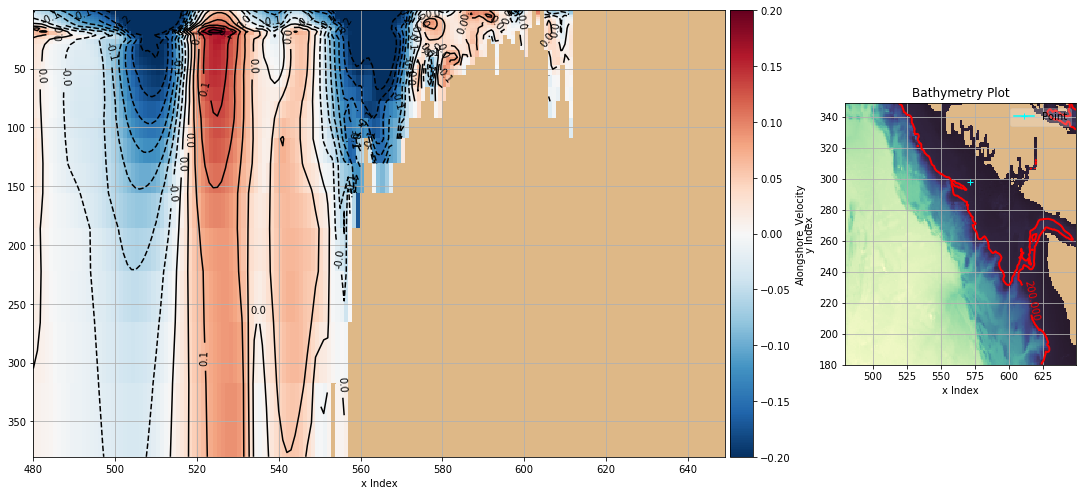

In [71]:
j = 88 +30

import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=-0.1,vmax=0.1)



# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], cmap=cmap, vmin=0)
axr.plot(
    x_wcvi_slice[i], y_wcvi_slice[j],
    linestyle='-', marker='+', color='cyan',
    label='Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()



t = 47 

v_0 = v_total[t, :30, :,:]
v_masked = np.ma.array(v_0, mask =1- v_mask)



cmap = plt.cm.get_cmap('RdBu_r')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:30])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], np.arange(-0.2, 0.2, 0.03), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
# axl.set_title('Vertical section across Esteban Point indicated on the adjacent bathy map after model run of 2 days')
plt.show()

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


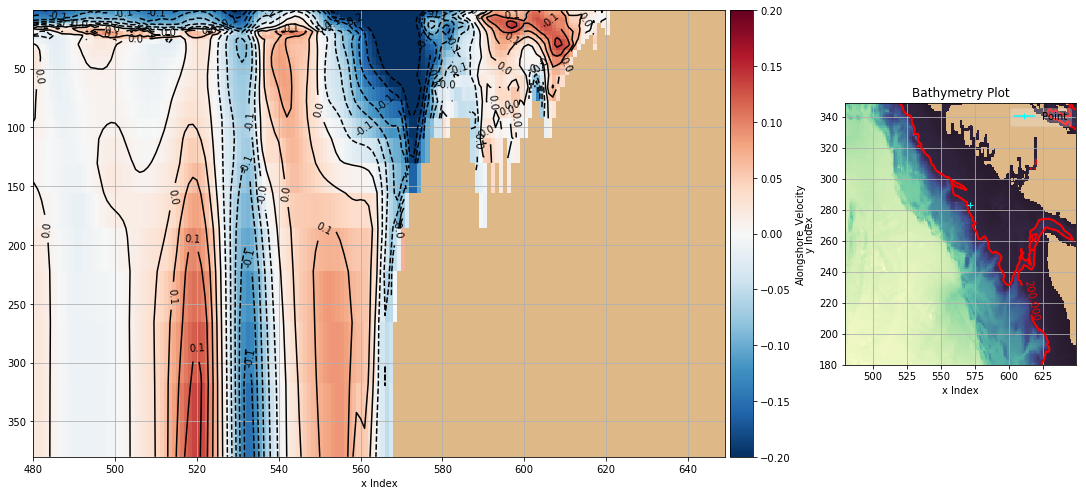

In [73]:
j = 88 +15

import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=-0.1,vmax=0.1)



# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], cmap=cmap, vmin=0)
axr.plot(
    x_wcvi_slice[i], y_wcvi_slice[j],
    linestyle='-', marker='+', color='cyan',
    label='Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()



t = 47 

v_0 = v_total[t, :30, :,:]
v_masked = np.ma.array(v_0, mask =1- v_mask)



cmap = plt.cm.get_cmap('RdBu_r')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:30])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], np.arange(-0.2, 0.2, 0.03), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
# axl.set_title('Vertical section across Esteban Point indicated on the adjacent bathy map after model run of 2 days')
plt.show()

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


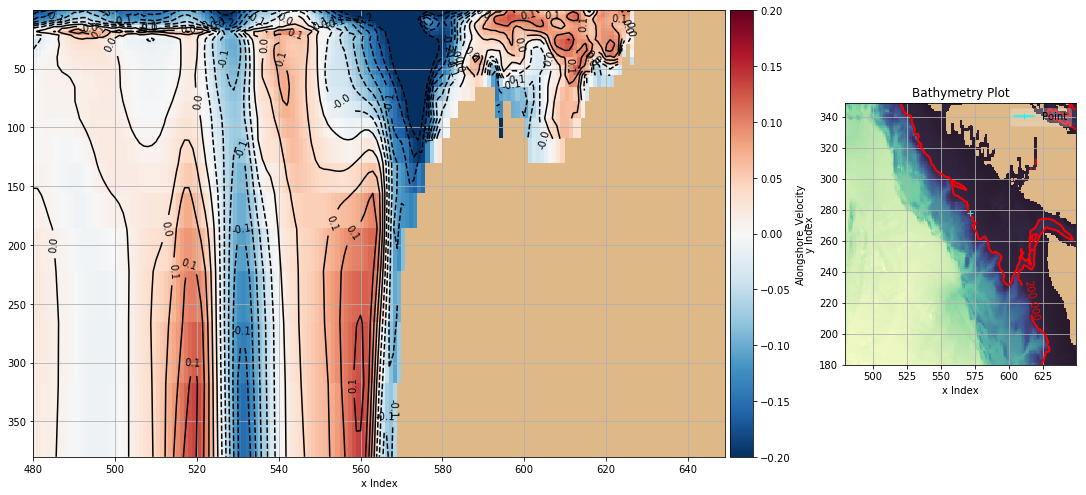

In [74]:
j = 88 + 10

import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=-0.1,vmax=0.1)



# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], cmap=cmap, vmin=0)
axr.plot(
    x_wcvi_slice[i], y_wcvi_slice[j],
    linestyle='-', marker='+', color='cyan',
    label='Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()



t = 47 

v_0 = v_total[t, :30, :,:]
v_masked = np.ma.array(v_0, mask =1- v_mask)



cmap = plt.cm.get_cmap('RdBu_r')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:30])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], np.arange(-0.2, 0.2, 0.03), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
# axl.set_title('Vertical section across Esteban Point indicated on the adjacent bathy map after model run of 2 days')
plt.show()

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


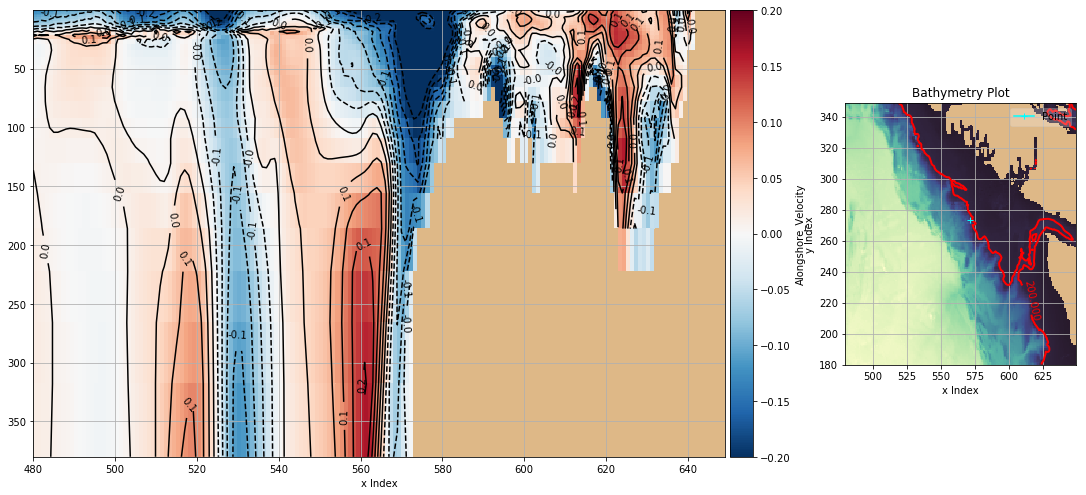

In [75]:
j = 88 + 5

import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=-0.1,vmax=0.1)



# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], cmap=cmap, vmin=0)
axr.plot(
    x_wcvi_slice[i], y_wcvi_slice[j],
    linestyle='-', marker='+', color='cyan',
    label='Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()



t = 47 

v_0 = v_total[t, :30, :,:]
v_masked = np.ma.array(v_0, mask =1- v_mask)



cmap = plt.cm.get_cmap('RdBu_r')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:30])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], np.arange(-0.2, 0.2, 0.03), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
# axl.set_title('Vertical section across Esteban Point indicated on the adjacent bathy map after model run of 2 days')
plt.show()

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


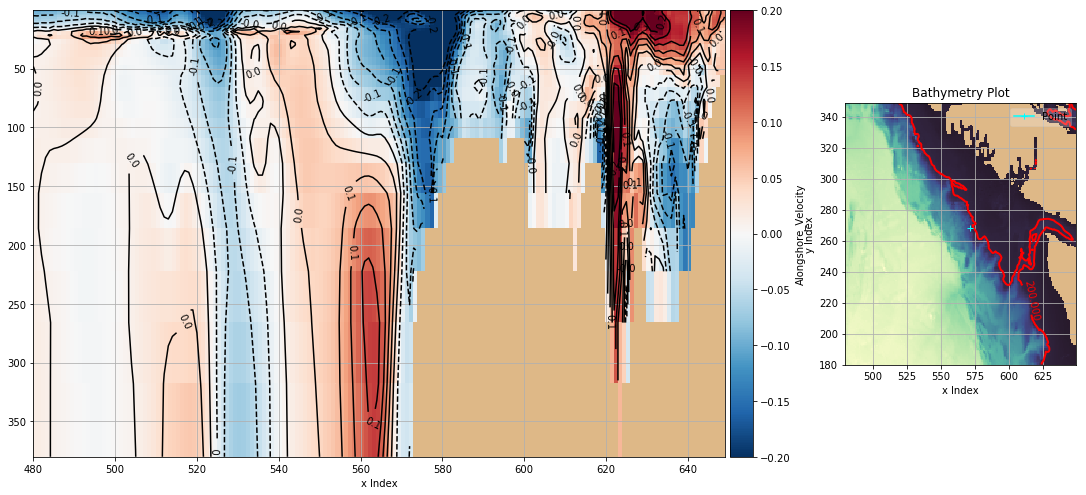

In [63]:
import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=-0.1,vmax=0.1)



# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], cmap=cmap, vmin=0)
axr.plot(
    x_wcvi_slice[i], y_wcvi_slice[j],
    linestyle='-', marker='+', color='cyan',
    label='Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()



t = 47 

v_0 = v_total[t, :30, :,:]
v_masked = np.ma.array(v_0, mask =1- v_mask)



cmap = plt.cm.get_cmap('RdBu_r')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:30])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], np.arange(-0.2, 0.2, 0.03), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
# axl.set_title('Vertical section across Esteban Point indicated on the adjacent bathy map after model run of 2 days')
plt.show()

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


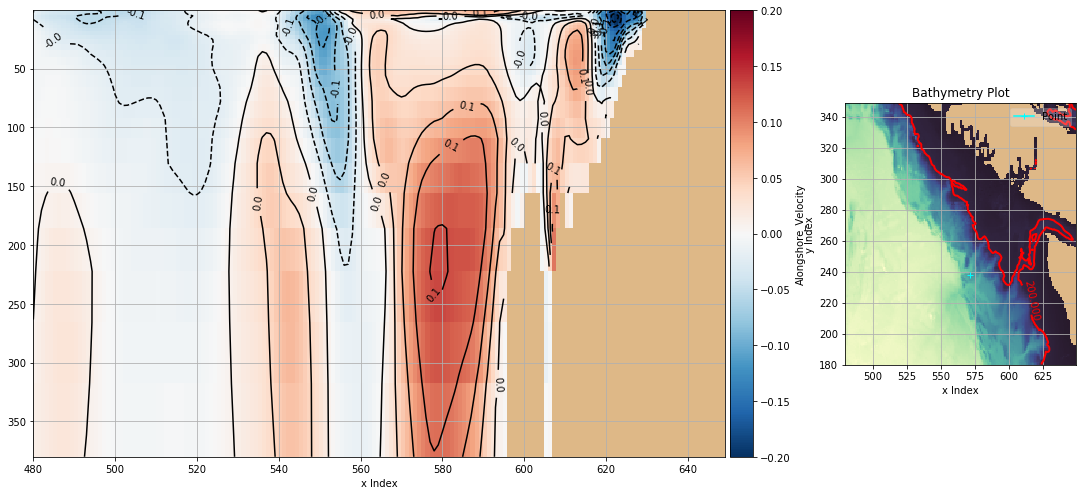

In [86]:
j = 88-30
t = 70

import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=-0.1,vmax=0.1)



# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], cmap=cmap, vmin=0)
axr.plot(
    x_wcvi_slice[i], y_wcvi_slice[j],
    linestyle='-', marker='+', color='cyan',
    label='Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()





v_0 = v_total[t, :30, :,:]
v_masked = np.ma.array(v_0, mask =1- v_mask)



cmap = plt.cm.get_cmap('RdBu_r')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:30])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], np.arange(-0.2, 0.2, 0.03), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
# axl.set_title('Vertical section across Esteban Point indicated on the adjacent bathy map after model run of 2 days')
plt.show()

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


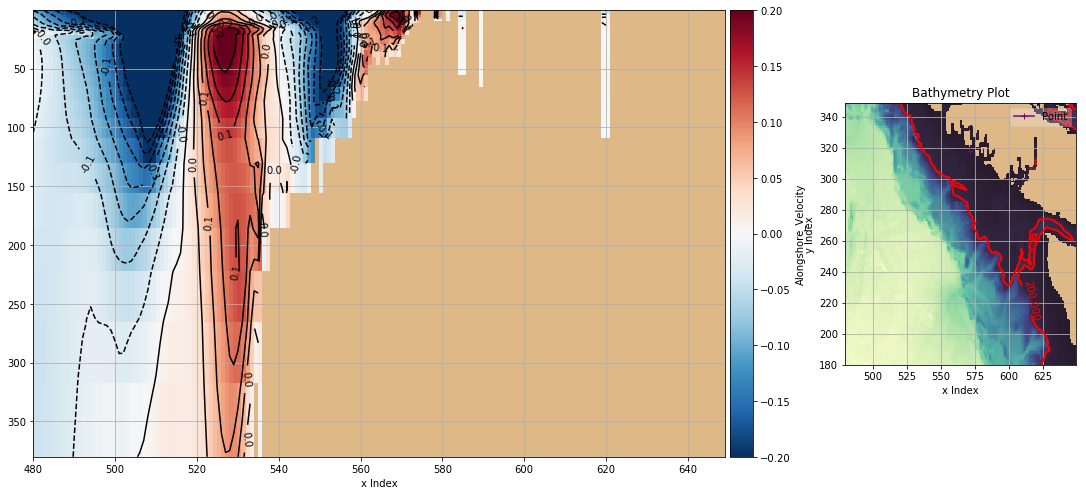

In [58]:
j = j + 50

import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=-0.1,vmax=0.1)



# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], cmap=cmap, vmin=0)
axr.plot(
    x_wcvi_slice[i], y_wcvi_slice[j],
    linestyle='-', marker='+', color='purple',
    label='Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()



t = 47 

v_0 = v_total[t, :30, :,:]
v_masked = np.ma.array(v_0, mask =1- v_mask)



cmap = plt.cm.get_cmap('RdBu_r')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_slice, zlevels[:30])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], np.arange(-0.2, 0.2, 0.03), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
# axl.set_title('Vertical section across Esteban Point indicated on the adjacent bathy map after model run of 2 days')
plt.show()

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


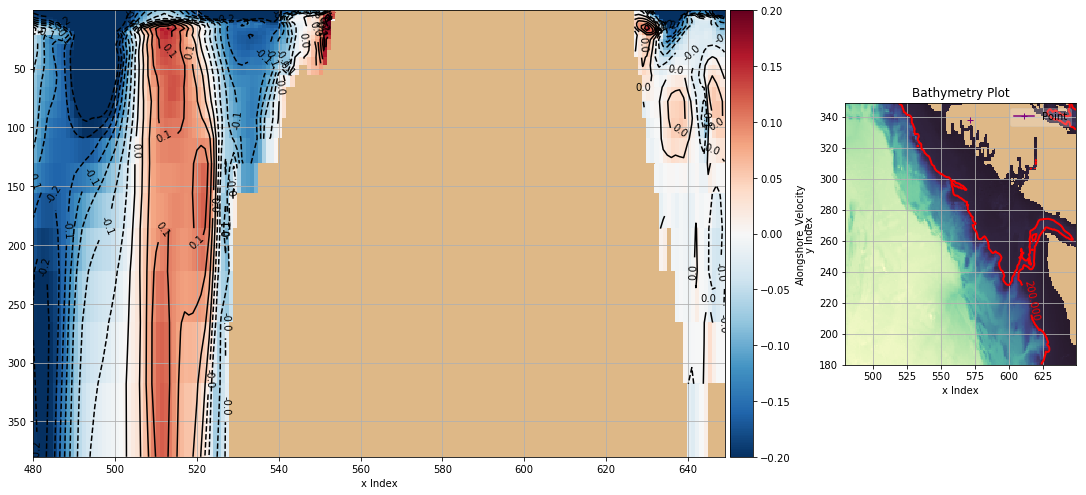

In [59]:
j = j + 20

import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=-0.1,vmax=0.1)



# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], cmap=cmap, vmin=0)
axr.plot(
    x_wcvi_slice[i], y_wcvi_slice[j],
    linestyle='-', marker='+', color='purple',
    label='Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()



t = 47 

v_0 = v_total[t, :30, :,:]
v_masked = np.ma.array(v_0, mask =1- v_mask)



cmap = plt.cm.get_cmap('RdBu_r')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_slice, zlevels[:30])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], np.arange(-0.2, 0.2, 0.03), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
# axl.set_title('Vertical section across Esteban Point indicated on the adjacent bathy map after model run of 2 days')
plt.show()

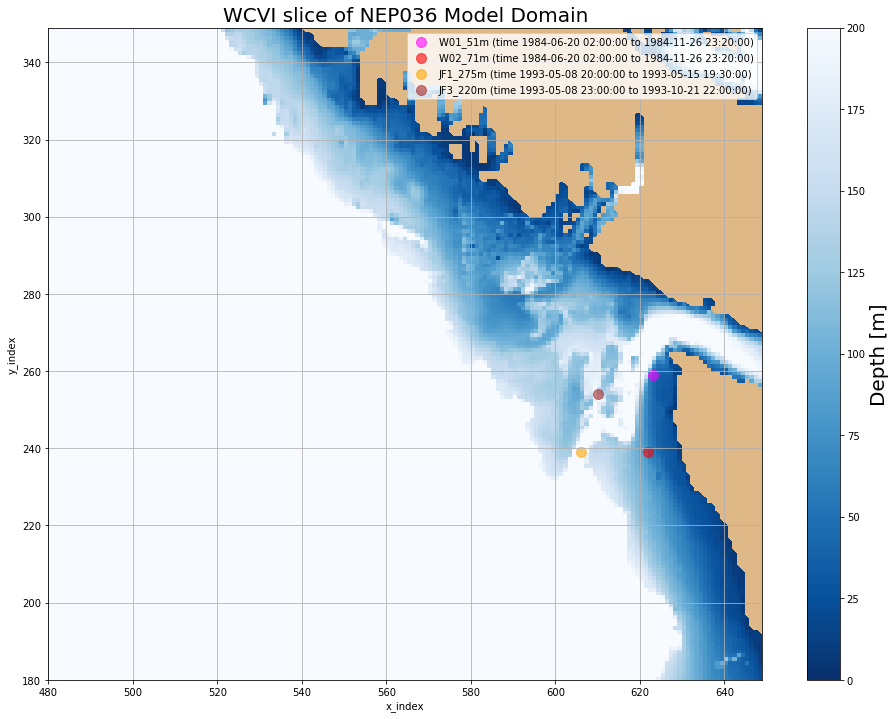

In [117]:
bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')


Z = bathy.variables['Bathymetry']

y_wcvi_slice = np.arange(180,350)
x_wcvi_slice = np.arange(480,650)



lon_model = bathy['nav_lon'][...]
lat_model = bathy['nav_lat'][...]


cmap = plt.get_cmap('Blues_r')

cmap.set_bad('burlywood')
fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
p = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], cmap=cmap, vmin=0, vmax=200)




lon_W01 = -124.82500
lat_W01 = 48.31500

j, i = geo_tools.find_closest_model_point(lon_W01,lat_W01,\
                                          lon_model,lat_model,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})      
ax.scatter(i, j, c='magenta', s=100, alpha=0.6, label = 'W01_51m (time 1984-06-20 02:00:00 to 1984-11-26 23:20:00)')

lon_W02 = -124.89500
lat_W02 = 48.04167

y, x = geo_tools.find_closest_model_point(lon_W02,lat_W02,\
                                          lon_model,lat_model,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
ax.scatter(x, y, c='red', s=100, alpha=0.6, label = 'W02_71m (time 1984-06-20 02:00:00 to 1984-11-26 23:20:00)')

lon_JF1 = -125.31383
lat_JF1 = 48.05433

q, ps = geo_tools.find_closest_model_point(lon_JF1,lat_JF1,\
                                          lon_model,lat_model,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
ax.scatter(ps, q, c='orange', s=100, alpha=0.6, label = 'JF1_275m (time 1993-05-08 20:00:00 to 1993-05-15 19:30:00)')

lon_JF3 = -125.20267
lat_JF3 = 48.25867

n, m = geo_tools.find_closest_model_point(lon_JF3,lat_JF3,\
                                          lon_model,lat_model,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
ax.scatter(m, n, c='brown', s=100, alpha=0.6, label = 'JF3_220m (time 1993-05-08 23:00:00 to 1993-10-21 22:00:00)')

legend = ax.legend(loc='best', fancybox=True, framealpha=0.8)
ax.set_xlabel('x_index')
ax.set_ylabel('y_index')
ax.set_title('WCVI slice of NEP036 Model Domain', fontsize=20)
viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
cbar = fig.colorbar(p, ax=ax)
cbar.ax.set_ylabel('Depth [m]', fontsize=20)
ax.grid()
plt.show()


In [118]:
lon_slice = lon[180:350,480:650]
lat_slice = lat[180:350,480:650]

In [119]:
lon_slice = lon_slice[1:,1:]
lat_slice = lat_slice[1:, 1:]

In [120]:

j, i = geo_tools.find_closest_model_point(lon_W01,lat_W01,\
                                          lon_slice,lat_slice,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 

print(j,i)

78 142


/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


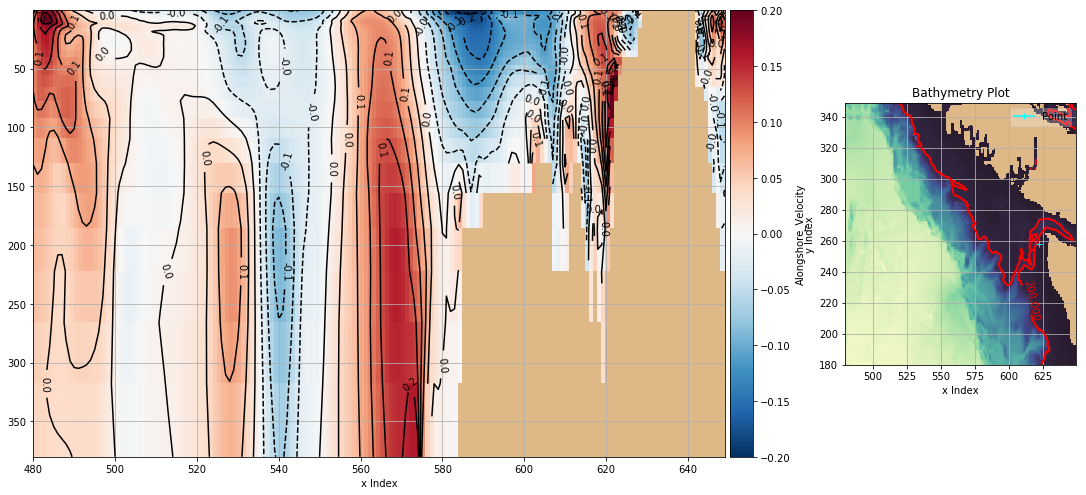

In [30]:
# j = j + 20

j = j
t =0

import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=-0.1,vmax=0.1)



# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], cmap=cmap, vmin=0)
axr.plot(
    x_wcvi_slice[i], y_wcvi_slice[j],
    linestyle='-', marker='+', color='cyan',
    label='Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()





v_0 = v_total[t, :30, :,:]
v_masked = np.ma.array(v_0, mask =1- v_mask)



cmap = plt.cm.get_cmap('RdBu_r')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:30])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], np.arange(-0.2, 0.2, 0.03), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
# axl.set_title('Vertical section across Esteban Point indicated on the adjacent bathy map after model run of 2 days')
plt.show()

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


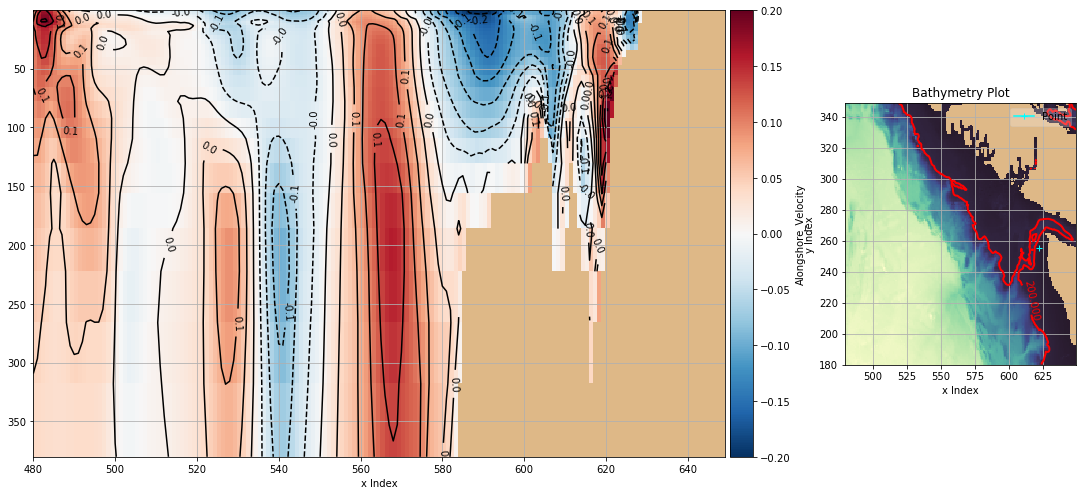

In [31]:
j = 78-3
t =0

import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=-0.1,vmax=0.1)



# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], cmap=cmap, vmin=0)
axr.plot(
    x_wcvi_slice[i], y_wcvi_slice[j],
    linestyle='-', marker='+', color='cyan',
    label='Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()





v_0 = v_total[t, :30, :,:]
v_masked = np.ma.array(v_0, mask =1- v_mask)



cmap = plt.cm.get_cmap('RdBu_r')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:30])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], np.arange(-0.2, 0.2, 0.03), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
# axl.set_title('Vertical section across Esteban Point indicated on the adjacent bathy map after model run of 2 days')
plt.show()

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


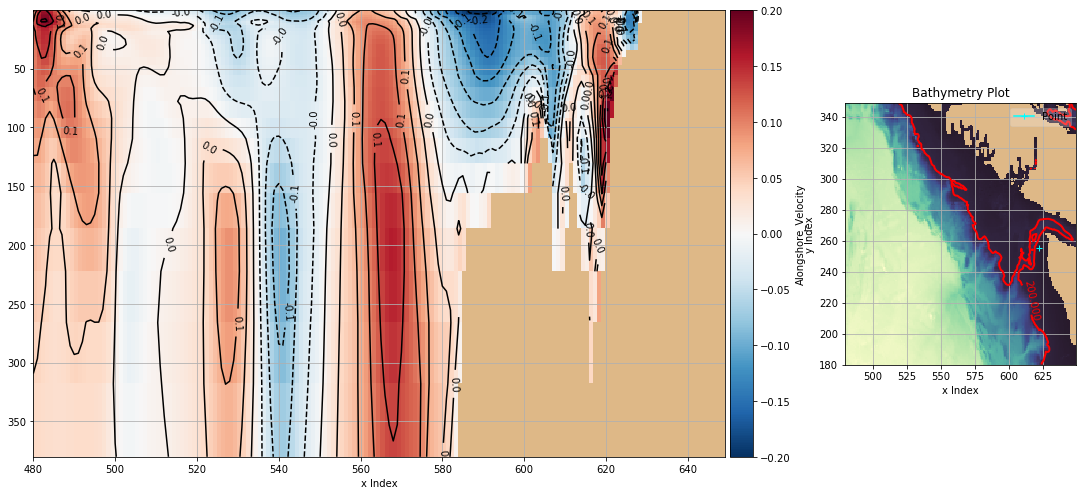

In [142]:
j = 78-3
t = 0

import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=-0.1,vmax=0.1)



# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], cmap=cmap, vmin=0)
axr.plot(
    x_wcvi_slice[i], y_wcvi_slice[j],
    linestyle='-', marker='+', color='cyan',
    label='Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()





v_0 = v_total[t, :30, :,:]
v_masked = np.ma.array(v_0, mask =1- v_mask)



cmap = plt.cm.get_cmap('RdBu_r')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:30])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], np.arange(-0.2, 0.2, 0.03), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
# axl.set_title('Vertical section across Esteban Point indicated on the adjacent bathy map after model run of 2 days')
plt.show()

In [40]:
NEP_aug = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/NEP36_T_S_Spice_aug_larger_offshore_rho_correct.nc')


sal_aug = NEP_aug.variables['vosaline'][:,:,y_wcvi_slice[:],x_wcvi_slice[:]]
temp_aug = NEP_aug.variables['votemper'][:,:,y_wcvi_slice[:],x_wcvi_slice[:]]
spic_aug = NEP_aug.variables['spiciness'][:,:,y_wcvi_slice[:],x_wcvi_slice[:]]
rho_aug = NEP_aug.variables['density'][:,:,y_wcvi_slice[:],x_wcvi_slice[:]]

zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht']


NEP_jul = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/NEP36_T_S_Spice_july_larger_offshore_rho_correct.nc')


sal_jul  = NEP_jul.variables['vosaline'][:,:,y_wcvi_slice[:],x_wcvi_slice[:]]
temp_jul = NEP_jul.variables['votemper'][:,:,y_wcvi_slice[:],x_wcvi_slice[:]]
spic_jul = NEP_jul.variables['spiciness'][:,:,y_wcvi_slice[:],x_wcvi_slice[:]]
rho_jul = NEP_jul.variables['density'][:,:,y_wcvi_slice[:],x_wcvi_slice[:]]

NEP_june = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/NEP36_T_S_Spice_june_larger_offshore_rho_correct.nc')


sal_june = NEP_june.variables['vosaline'][:,:,y_wcvi_slice[:],x_wcvi_slice[:]]
temp_june = NEP_june.variables['votemper'][:,:,y_wcvi_slice[:],x_wcvi_slice[:]]
spic_june = NEP_june.variables['spiciness'][:,:,y_wcvi_slice[:],x_wcvi_slice[:]]
rho_june = NEP_june.variables['density'][:,:,y_wcvi_slice[:],x_wcvi_slice[:]]

In [137]:
def plot_shelf_slice(t, j, i, month):
    import matplotlib as mpl

    norm = mpl.colors.Normalize(vmin=-0.1,vmax=0.1)
    
    if month == 'June':
        v_0 = v_jun[t, :30, :, :]
        v_masked = np.ma.array(v_0, mask =1- v_mask)
        rho_0 = rho_june[t,:30,:,:] - 1000
            
    if month == 'July':
        v_0 = v_july[t, :30, :,:]
        v_masked = np.ma.array(v_0, mask =1- v_mask)
        rho_0 = rho_jul[t,:30,:,:] - 1000
            
    if month == 'August':
        v_0 = v_aug[t, :30, :,:]
        v_masked = np.ma.array(v_0, mask =1- v_mask)
        rho_0 = rho_aug[t,:30,:,:] - 1000
            
    # Set up the figure and axes
    fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
    land_colour = 'burlywood'
    for ax in (axl, axr):
        ax.set_axis_bgcolor(land_colour)
    axl.set_position((0.125, 0.125, 0.6, 0.775))
    axcb.set_position((0.73, 0.125, 0.02, 0.775))
    axr.set_position((0.83, 0.125, 0.2, 0.775))

    # Plot thalweg points on bathymetry map
    viz_tools.set_aspect(axr)
    cmap = plt.get_cmap(cmo.cm.deep_r)
    cmap.set_bad(land_colour)
    # bathy = bathymetry
    # x_slice = np.arange(bathy.shape[1])
    # y_slice = np.arange(bathy.shape[0])
    axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], cmap=cmap, vmin=0)
    axr.plot(
        x_wcvi_slice[i], y_wcvi_slice[j],
        linestyle='-', marker='+', color='cyan',
        label='Point',
    )
    legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
    axr.set_title('Bathymetry Plot')
    axr.set_xlabel('x Index')
    axr.set_ylabel('y Index')
    CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], levels = [200],
                     colors=('red',),linestyles=('-',),linewidths=(2,))


    axr.clabel(CS)
    axr.grid()
    
    cmap = plt.cm.get_cmap('RdBu_r')
    cmap.set_bad(land_colour)
    x, z = np.meshgrid(x_wcvi_slice, zlevels[:30])
    mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], cmap=cmap, vmin = -0.2, vmax = 0.2)
    cbar = plt.colorbar(mesh, cax=axcb)
    cbar.set_label('Alongshore_Velocity')
    clines = axl.contour(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], np.arange(-0.2, 0.2, 0.03), colors='black')
    rho_tzyx = np.ma.array(rho_0, mask = 1 - t_mask)    
    clines = axl.contour(x_wcvi_slice, zlevels[:30], rho_tzyx[:30,j,:], np.arange(25.0, 26.5, 0.1), colors='magenta')
    axl.clabel(clines, fmt='%1.1f', inline=True)
    axl.invert_yaxis()
    axl.set_xlabel('x Index')
    # axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
    axl.grid()
    
    if month == 'June':
        axl.set_title("Section (x-z) on {0} June 2015".format(t+1))
        plt.savefig('/home/ssahu/saurav/3D_images_for_video_spice/W01_{0}.png'.format(t))
        
    if month == 'July': 
        axl.set_title("Section (x-z) on {0} July 2015".format(t+1))
        plt.savefig('/home/ssahu/saurav/3D_images_for_video_spice/W01_{0}.png'.format(t+30))
        
    if month == 'August':
        axl.set_title("Section (x-z) on {0} August 2015".format(t+1))
        plt.savefig('/home/ssahu/saurav/3D_images_for_video_spice/W01_{0}.png'.format(t+61))        
    
    plt.close()
        
    

            
    
            
    
    
    
    

In [139]:
j = 78


# for t in np.arange(v_jun.shape[0]):
#     plot_shelf_slice(t, j, i, 'June')

for t in np.arange(v_july.shape[0]):
    plot_shelf_slice(t, j, i, 'July')
    
for t in np.arange(v_aug.shape[0]):
    plot_shelf_slice(t, j, i, 'August')

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


In [141]:
j = 78-3


for t in np.arange(v_jun.shape[0]):
    plot_shelf_slice(t, j, i, 'June')

# for t in np.arange(v_july.shape[0]):
#     plot_shelf_slice(t, j, i, 'July')
    
# for t in np.arange(v_aug.shape[0]):
#     plot_shelf_slice(t, j, i, 'August')

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


In [143]:
j = 78 - 10


for t in np.arange(v_jun.shape[0]):
    plot_shelf_slice(t, j, i, 'June')

for t in np.arange(v_july.shape[0]):
    plot_shelf_slice(t, j, i, 'July')
    
for t in np.arange(v_aug.shape[0]):
    plot_shelf_slice(t, j, i, 'August')

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


In [146]:
j = 78 - 20


for t in np.arange(v_jun.shape[0]):
    plot_shelf_slice(t, j, i, 'June')

for t in np.arange(v_july.shape[0]):
    plot_shelf_slice(t, j, i, 'July')
    
for t in np.arange(v_aug.shape[0]):
    plot_shelf_slice(t, j, i, 'August')

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


In [148]:
j = 78 + 10


for t in np.arange(v_jun.shape[0]):
    plot_shelf_slice(t, j, i, 'June')

for t in np.arange(v_july.shape[0]):
    plot_shelf_slice(t, j, i, 'July')
    
for t in np.arange(v_aug.shape[0]):
    plot_shelf_slice(t, j, i, 'August')

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


In [152]:
j = 78 + 25


for t in np.arange(v_jun.shape[0]):
    plot_shelf_slice(t, j, i, 'June')

for t in np.arange(v_july.shape[0]):
    plot_shelf_slice(t, j, i, 'July')
    
for t in np.arange(v_aug.shape[0]):
    plot_shelf_slice(t, j, i, 'August')

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


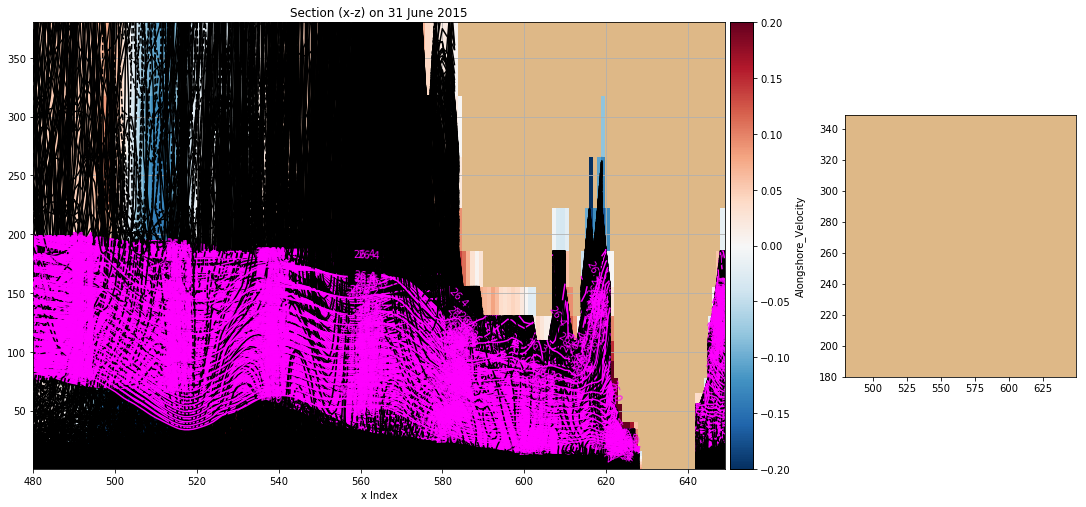

In [133]:
j = 78
t = 0
months = ['June', 'July', 'August']


import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=-0.1,vmax=0.1)



# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], cmap=cmap, vmin=0)
axr.plot(
    x_wcvi_slice[i], y_wcvi_slice[j],
    linestyle='-', marker='+', color='cyan',
    label='Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()




for month in months:





    if month == 'June':
        for t in np.arange(v_jun.shape[0]):
            v_0 = v_jun[t, :30, :,:]
            v_masked = np.ma.array(v_0, mask =1- v_mask)
            rho_0 = rho_june[t,:30,:,:] - 1000
            axl.set_title("Section (x-z) on {0} June 2015".format(t+1))
            cmap = plt.cm.get_cmap('RdBu_r')
            cmap.set_bad(land_colour)
            x, z = np.meshgrid(x_wcvi_slice, zlevels[:30])
            mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], cmap=cmap, vmin = -0.2, vmax = 0.2)
            cbar = plt.colorbar(mesh, cax=axcb)
            cbar.set_label('Alongshore_Velocity')
            clines = axl.contour(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], np.arange(-0.2, 0.2, 0.03), colors='black')
            rho_tzyx = np.ma.array(rho_0, mask = 1 - t_mask)    
            clines = axl.contour(x_wcvi_slice, zlevels[:30], rho_tzyx[:30,j,:], np.arange(25.0, 26.5, 0.1), colors='magenta')
            axl.clabel(clines, fmt='%1.1f', inline=True)
            axl.invert_yaxis()
            axl.set_xlabel('x Index')
            # axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
            axl.grid()
            plt.savefig('/home/ssahu/saurav/3D_images_for_video_spice/W01_{0}.png'.format(t))
            plt.cla()
            
    if month == 'July':
        for t in np.arange(v_july.shape[0]):
            v_0 = v_july[t, :30, :,:]
            v_masked = np.ma.array(v_0, mask =1- v_mask)
            rho_0 = rho_jul[t,:30,:,:] - 1000
            axl.set_title("Section (x-z) on {0} July 2015".format(t+1))
            cmap = plt.cm.get_cmap('RdBu_r')
            cmap.set_bad(land_colour)
            x, z = np.meshgrid(x_wcvi_slice, zlevels[:30])
            mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], cmap=cmap, vmin = -0.2, vmax = 0.2)
            cbar = plt.colorbar(mesh, cax=axcb)
            cbar.set_label('Alongshore_Velocity')
            clines = axl.contour(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], np.arange(-0.2, 0.2, 0.03), colors='black')
            rho_tzyx = np.ma.array(rho_0, mask = 1 - t_mask)    
            clines = axl.contour(x_wcvi_slice, zlevels[:30], rho_tzyx[:30,j,:], np.arange(25.0, 26.5, 0.1), colors='magenta')
            axl.clabel(clines, fmt='%1.1f', inline=True)
            axl.invert_yaxis()
            axl.set_xlabel('x Index')
            # axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
            axl.grid()
            plt.savefig('/home/ssahu/saurav/3D_images_for_video_spice/W01_{0}.png'.format(t+30))
            plt.cla()
            
    if month == 'August':
        for t in np.arange(v_aug.shape[0]):
            v_0 = v_aug[t, :30, :,:]
            v_masked = np.ma.array(v_0, mask =1- v_mask)
            rho_0 = rho_aug[t,:30,:,:] - 1000
            axl.set_title("Section (x-z) on {0} August 2015".format(t+1))
            cmap = plt.cm.get_cmap('RdBu_r')
            cmap.set_bad(land_colour)
            x, z = np.meshgrid(x_wcvi_slice, zlevels[:30])
            mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], cmap=cmap, vmin = -0.2, vmax = 0.2)
            cbar = plt.colorbar(mesh, cax=axcb)
            cbar.set_label('Alongshore_Velocity')
            clines = axl.contour(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], np.arange(-0.2, 0.2, 0.03), colors='black')
            rho_tzyx = np.ma.array(rho_0, mask = 1 - t_mask)    
            clines = axl.contour(x_wcvi_slice, zlevels[:30], rho_tzyx[:30,j,:], np.arange(25.0, 26.5, 0.1), colors='magenta')
            axl.clabel(clines, fmt='%1.1f', inline=True)
            axl.invert_yaxis()
            axl.set_xlabel('x Index')
            # axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
            axl.grid()
            plt.savefig('/home/ssahu/saurav/3D_images_for_video_spice/W01_{0}.png'.format(t+61))
            plt.cla()







/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


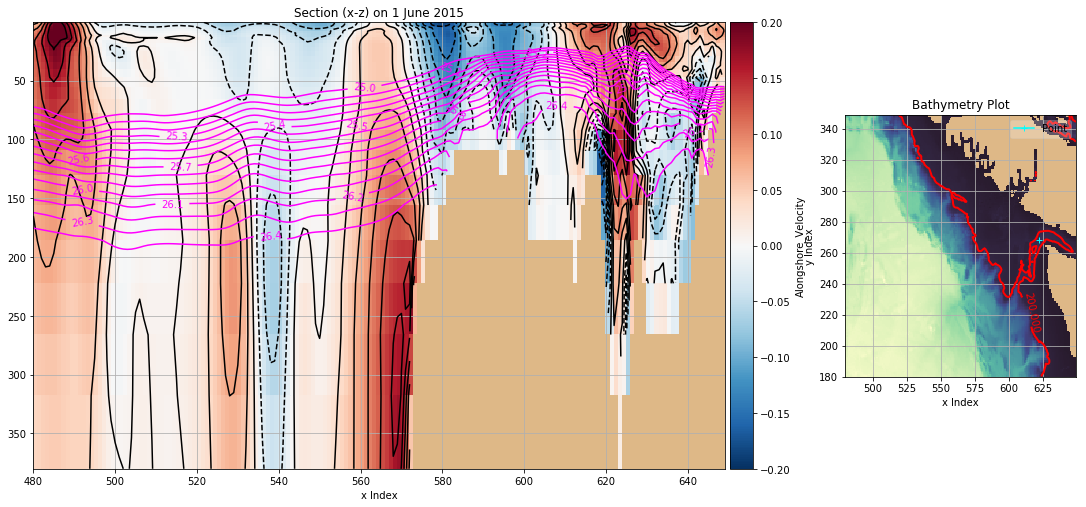

In [147]:
j = 78 + 10
t = 0
month = 'June'


import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=-0.1,vmax=0.1)







# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], cmap=cmap, vmin=0)
axr.plot(
    x_wcvi_slice[i], y_wcvi_slice[j],
    linestyle='-', marker='+', color='cyan',
    label='Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()





v_0 = v_total[t, :30, :,:]
v_masked = np.ma.array(v_0, mask =1- v_mask)



cmap = plt.cm.get_cmap('RdBu_r')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:30])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], np.arange(-0.2, 0.2, 0.03), colors='black')

if month == 'June':
    rho_0 = rho_june[t,:30,:,:] - 1000
    axl.set_title("Section (x-z) on {0} June 2015".format(t+1))

rho_tzyx = np.ma.array(rho_0, mask = 1 - t_mask)    
clines = axl.contour(x_wcvi_slice, zlevels[:30], rho_tzyx[:30,j,:], np.arange(25.0, 26.5, 0.1), colors='magenta')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
# axl.set_title('Vertical section across Esteban Point indicated on the adjacent bathy map after model run of 2 days')


/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


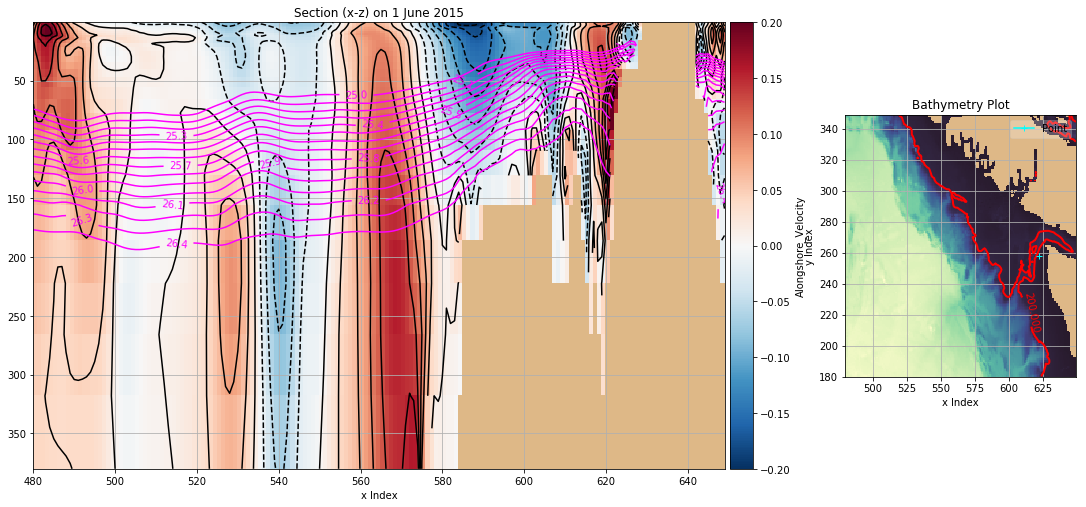

In [144]:
j = 78
t = 0
month = 'June'


import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=-0.1,vmax=0.1)







# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], cmap=cmap, vmin=0)
axr.plot(
    x_wcvi_slice[i], y_wcvi_slice[j],
    linestyle='-', marker='+', color='cyan',
    label='Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()





v_0 = v_total[t, :30, :,:]
v_masked = np.ma.array(v_0, mask =1- v_mask)



cmap = plt.cm.get_cmap('RdBu_r')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:30])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], np.arange(-0.2, 0.2, 0.03), colors='black')

if month == 'June':
    rho_0 = rho_june[t,:30,:,:] - 1000
    axl.set_title("Section (x-z) on {0} June 2015".format(t+1))

rho_tzyx = np.ma.array(rho_0, mask = 1 - t_mask)    
clines = axl.contour(x_wcvi_slice, zlevels[:30], rho_tzyx[:30,j,:], np.arange(25.0, 26.5, 0.1), colors='magenta')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
# axl.set_title('Vertical section across Esteban Point indicated on the adjacent bathy map after model run of 2 days')


/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


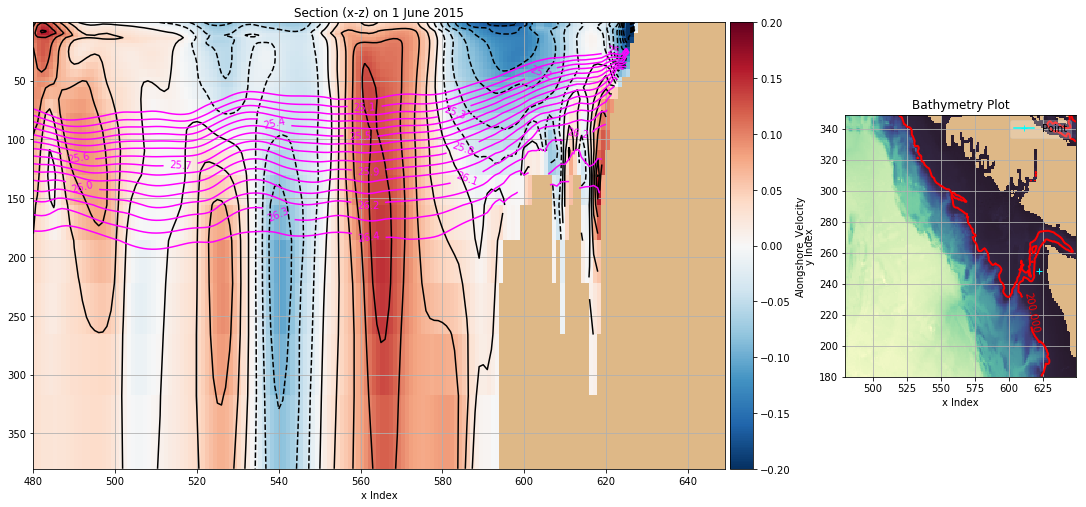

In [145]:
j = 78 - 10
t = 0
month = 'June'


import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=-0.1,vmax=0.1)







# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], cmap=cmap, vmin=0)
axr.plot(
    x_wcvi_slice[i], y_wcvi_slice[j],
    linestyle='-', marker='+', color='cyan',
    label='Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()





v_0 = v_total[t, :30, :,:]
v_masked = np.ma.array(v_0, mask =1- v_mask)



cmap = plt.cm.get_cmap('RdBu_r')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:30])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], np.arange(-0.2, 0.2, 0.03), colors='black')

if month == 'June':
    rho_0 = rho_june[t,:30,:,:] - 1000
    axl.set_title("Section (x-z) on {0} June 2015".format(t+1))

rho_tzyx = np.ma.array(rho_0, mask = 1 - t_mask)    
clines = axl.contour(x_wcvi_slice, zlevels[:30], rho_tzyx[:30,j,:], np.arange(25.0, 26.5, 0.1), colors='magenta')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
# axl.set_title('Vertical section across Esteban Point indicated on the adjacent bathy map after model run of 2 days')


/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


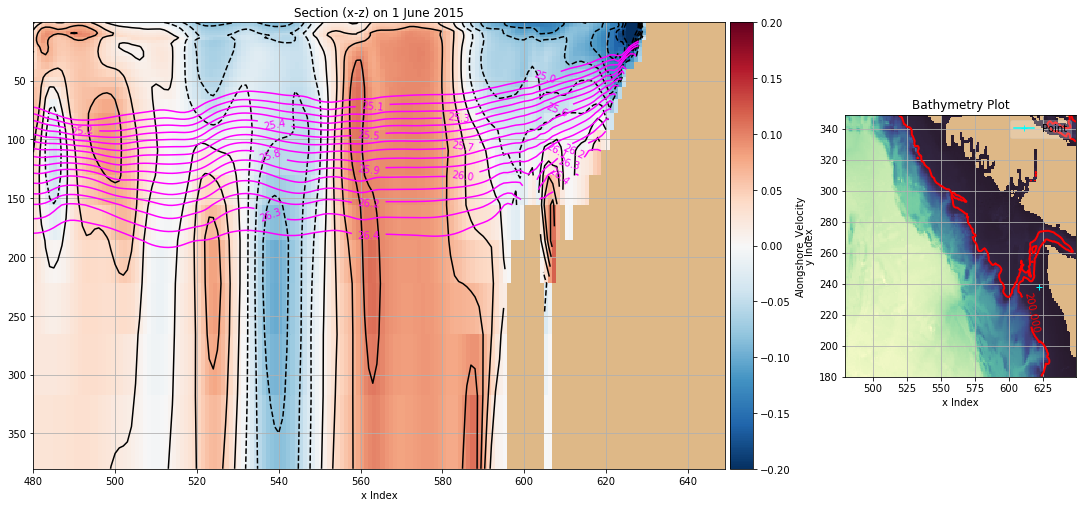

In [122]:
j = 78-20
t = 0
month = 'June'


import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=-0.1,vmax=0.1)







# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], cmap=cmap, vmin=0)
axr.plot(
    x_wcvi_slice[i], y_wcvi_slice[j],
    linestyle='-', marker='+', color='cyan',
    label='Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()





v_0 = v_total[t, :30, :,:]
v_masked = np.ma.array(v_0, mask =1- v_mask)



cmap = plt.cm.get_cmap('RdBu_r')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:30])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], np.arange(-0.2, 0.2, 0.03), colors='black')

if month == 'June':
    rho_0 = rho_june[t,:30,:,:] - 1000
    axl.set_title("Section (x-z) on {0} June 2015".format(t+1))

rho_tzyx = np.ma.array(rho_0, mask = 1 - t_mask)    
clines = axl.contour(x_wcvi_slice, zlevels[:30], rho_tzyx[:30,j,:], np.arange(25.0, 26.5, 0.1), colors='magenta')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
# axl.set_title('Vertical section across Esteban Point indicated on the adjacent bathy map after model run of 2 days')


/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


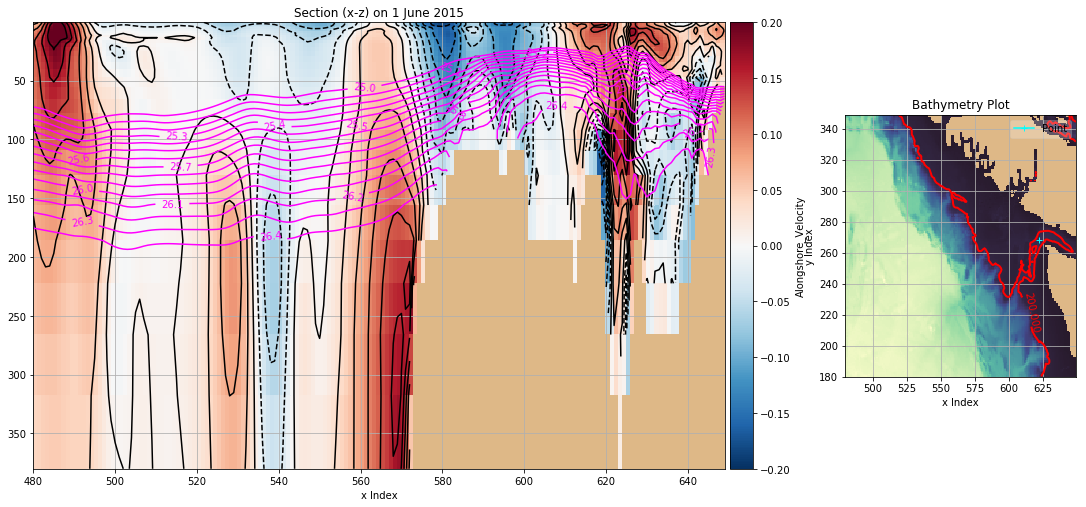

In [124]:
j = 78+10
t = 0
month = 'June'


import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=-0.1,vmax=0.1)







# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], cmap=cmap, vmin=0)
axr.plot(
    x_wcvi_slice[i], y_wcvi_slice[j],
    linestyle='-', marker='+', color='cyan',
    label='Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()





v_0 = v_total[t, :30, :,:]
v_masked = np.ma.array(v_0, mask =1- v_mask)



cmap = plt.cm.get_cmap('RdBu_r')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:30])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], np.arange(-0.2, 0.2, 0.03), colors='black')

if month == 'June':
    rho_0 = rho_june[t,:30,:,:] - 1000
    axl.set_title("Section (x-z) on {0} June 2015".format(t+1))

rho_tzyx = np.ma.array(rho_0, mask = 1 - t_mask)    
clines = axl.contour(x_wcvi_slice, zlevels[:30], rho_tzyx[:30,j,:], np.arange(25.0, 26.5, 0.1), colors='magenta')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
# axl.set_title('Vertical section across Esteban Point indicated on the adjacent bathy map after model run of 2 days')


/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


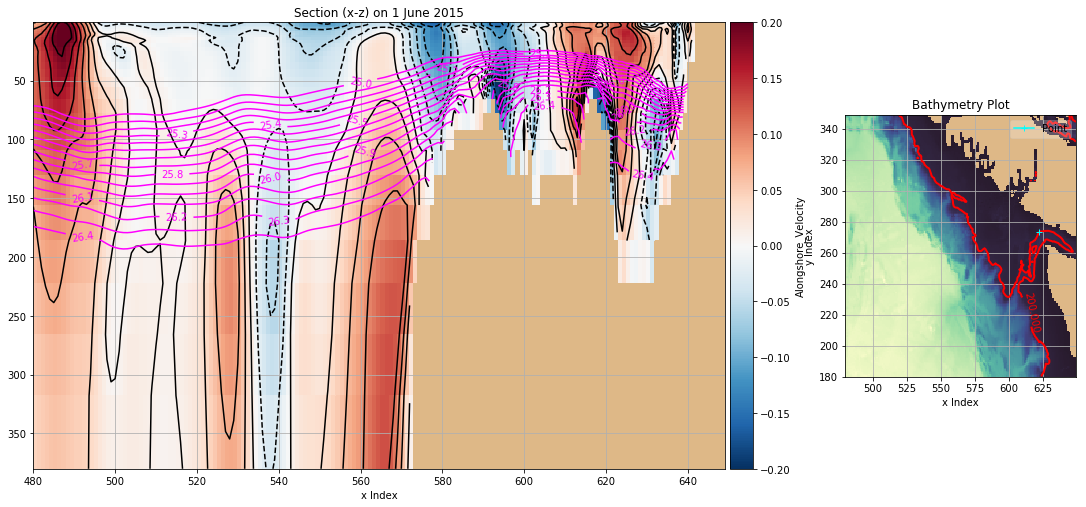

In [125]:
j = 78+15
t = 0
month = 'June'


import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=-0.1,vmax=0.1)







# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], cmap=cmap, vmin=0)
axr.plot(
    x_wcvi_slice[i], y_wcvi_slice[j],
    linestyle='-', marker='+', color='cyan',
    label='Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()





v_0 = v_total[t, :30, :,:]
v_masked = np.ma.array(v_0, mask =1- v_mask)



cmap = plt.cm.get_cmap('RdBu_r')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:30])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], np.arange(-0.2, 0.2, 0.03), colors='black')

if month == 'June':
    rho_0 = rho_june[t,:30,:,:] - 1000
    axl.set_title("Section (x-z) on {0} June 2015".format(t+1))

rho_tzyx = np.ma.array(rho_0, mask = 1 - t_mask)    
clines = axl.contour(x_wcvi_slice, zlevels[:30], rho_tzyx[:30,j,:], np.arange(25.0, 26.5, 0.1), colors='magenta')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
# axl.set_title('Vertical section across Esteban Point indicated on the adjacent bathy map after model run of 2 days')


/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


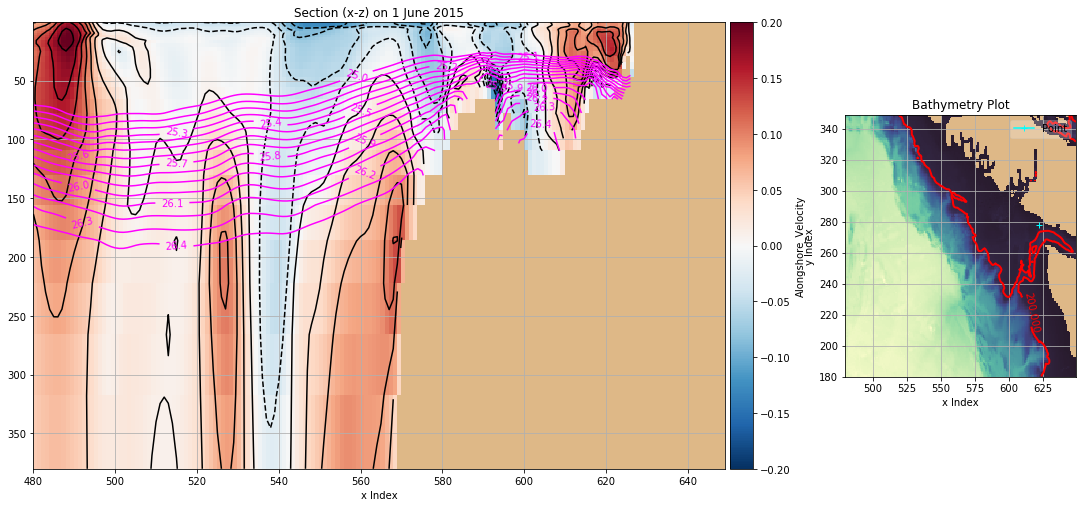

In [150]:
j = 78+20
t = 0
month = 'June'


import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=-0.1,vmax=0.1)







# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], cmap=cmap, vmin=0)
axr.plot(
    x_wcvi_slice[i], y_wcvi_slice[j],
    linestyle='-', marker='+', color='cyan',
    label='Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()





v_0 = v_total[t, :30, :,:]
v_masked = np.ma.array(v_0, mask =1- v_mask)



cmap = plt.cm.get_cmap('RdBu_r')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:30])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], np.arange(-0.2, 0.2, 0.03), colors='black')

if month == 'June':
    rho_0 = rho_june[t,:30,:,:] - 1000
    axl.set_title("Section (x-z) on {0} June 2015".format(t+1))

rho_tzyx = np.ma.array(rho_0, mask = 1 - t_mask)    
clines = axl.contour(x_wcvi_slice, zlevels[:30], rho_tzyx[:30,j,:], np.arange(25.0, 26.5, 0.1), colors='magenta')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
# axl.set_title('Vertical section across Esteban Point indicated on the adjacent bathy map after model run of 2 days')


/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


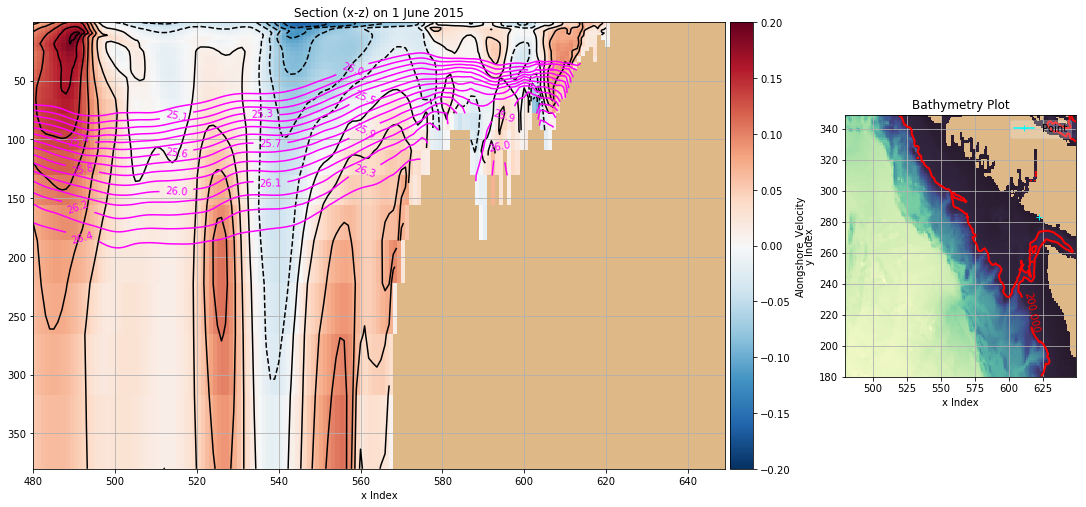

In [151]:
j = 78+25
t = 0
month = 'June'


import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=-0.1,vmax=0.1)







# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], cmap=cmap, vmin=0)
axr.plot(
    x_wcvi_slice[i], y_wcvi_slice[j],
    linestyle='-', marker='+', color='cyan',
    label='Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()





v_0 = v_total[t, :30, :,:]
v_masked = np.ma.array(v_0, mask =1- v_mask)



cmap = plt.cm.get_cmap('RdBu_r')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:30])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], np.arange(-0.2, 0.2, 0.03), colors='black')

if month == 'June':
    rho_0 = rho_june[t,:30,:,:] - 1000
    axl.set_title("Section (x-z) on {0} June 2015".format(t+1))

rho_tzyx = np.ma.array(rho_0, mask = 1 - t_mask)    
clines = axl.contour(x_wcvi_slice, zlevels[:30], rho_tzyx[:30,j,:], np.arange(25.0, 26.5, 0.1), colors='magenta')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
# axl.set_title('Vertical section across Esteban Point indicated on the adjacent bathy map after model run of 2 days')


/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


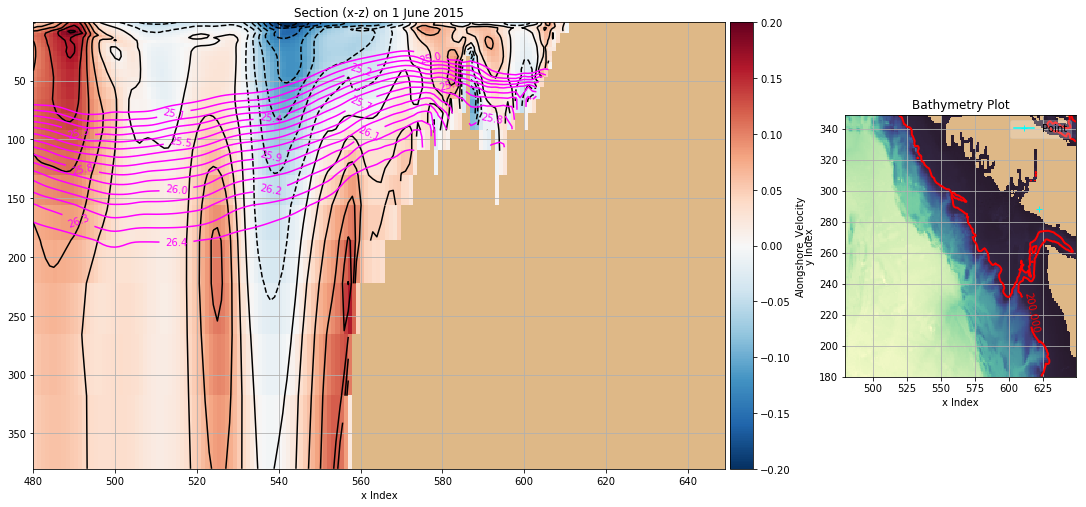

In [128]:
j = 78+30
t = 0
month = 'June'


import matplotlib as mpl

norm = mpl.colors.Normalize(vmin=-0.1,vmax=0.1)







# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], cmap=cmap, vmin=0)
axr.plot(
    x_wcvi_slice[i], y_wcvi_slice[j],
    linestyle='-', marker='+', color='cyan',
    label='Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[180:350,480:650], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()





v_0 = v_total[t, :30, :,:]
v_masked = np.ma.array(v_0, mask =1- v_mask)



cmap = plt.cm.get_cmap('RdBu_r')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:30])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_wcvi_slice, zlevels[:30], v_masked[:30,j,:], np.arange(-0.2, 0.2, 0.03), colors='black')

if month == 'June':
    rho_0 = rho_june[t,:30,:,:] - 1000
    axl.set_title("Section (x-z) on {0} June 2015".format(t+1))

rho_tzyx = np.ma.array(rho_0, mask = 1 - t_mask)    
clines = axl.contour(x_wcvi_slice, zlevels[:30], rho_tzyx[:30,j,:], np.arange(25.0, 26.5, 0.1), colors='magenta')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
# axl.set_title('Vertical section across Esteban Point indicated on the adjacent bathy map after model run of 2 days')


In [25]:
mag_total.shape

(122, 50, 170, 170)

In [6]:
u_total.shape

(122, 50, 170, 170)

In [16]:
date1 = '2015-08-03'
date2 = '2015-09-30'
mydates = np.array(pd.date_range(date1, date2))

In [79]:
mydates.shape

(59,)

In [68]:
lon_slice = lon[180:350,480:650]
lat_slice = lat[180:350,480:650]


lon_A1 = -126.20433
lat_A1 = 48.52958

j, i = geo_tools.find_closest_model_point(lon_A1,lat_A1,\
                                          lon_slice,lat_slice,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})   

In [60]:
zlevels[:]

array([  4.94025379e-01,   1.54137540e+00,   2.64566851e+00,
         3.81949472e+00,   5.07822371e+00,   6.44061422e+00,
         7.92956018e+00,   9.57299709e+00,   1.14050026e+01,
         1.34671383e+01,   1.58100729e+01,   1.84955597e+01,
         2.15988159e+01,   2.52114086e+01,   2.94447289e+01,
         3.44341545e+01,   4.03440514e+01,   4.73736877e+01,
         5.57642899e+01,   6.58072739e+01,   7.78538513e+01,
         9.23260727e+01,   1.09729279e+02,   1.30665985e+02,
         1.55850723e+02,   1.86125565e+02,   2.22475174e+02,
         2.66040253e+02,   3.18127441e+02,   3.80213013e+02,
         4.53937744e+02,   5.41088928e+02,   6.43566833e+02,
         7.63333069e+02,   9.02339294e+02,   1.06243970e+03,
         1.24529114e+03,   1.45225098e+03,   1.68428442e+03,
         1.94189343e+03,   2.22507788e+03,   2.53333618e+03,
         2.86570264e+03,   3.22082031e+03,   3.59703198e+03,
         3.99248389e+03,   4.40522412e+03,   4.83329053e+03,
         5.27478418e+03,

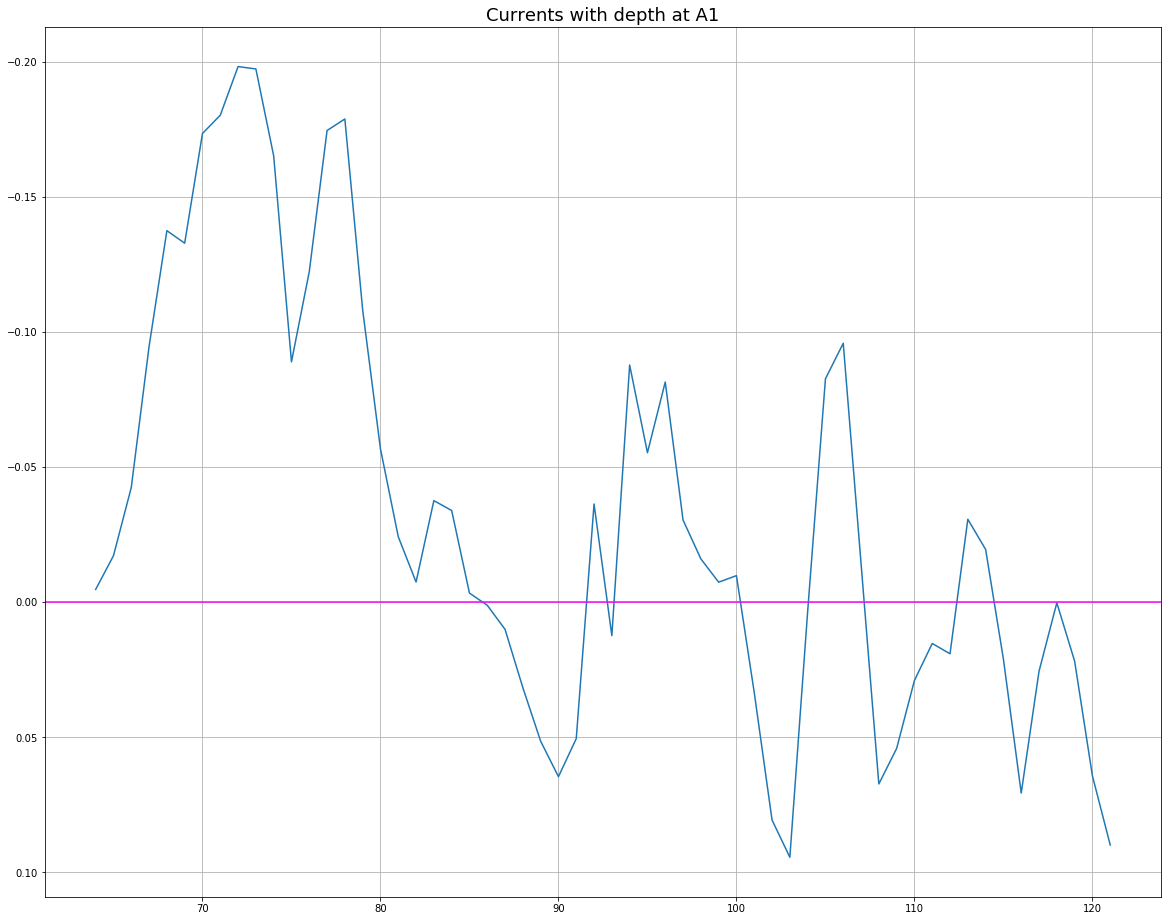

In [78]:
step = 1

# u_84 = vel_east_84[:4320]
# v_84 = vel_north_84[:4320]
# mag_84 = np.sqrt(u_84**2,v_84**2)

time_axis_quiver = np.arange(64,122,step)



# time_axis = datetime_A1[:2420]
# time_tick = time_axis[::step]
# time_axis_quiver = np.arange(0,2420,step)



fig, ax = plt.subplots(1, 1, figsize=(20,16))

ax.plot(time_axis_quiver, v_total[64:,10,j,i])
ax.axhline(y=0, color='magenta')
# ax.quiver(time_axis_quiver, zlevels[10], v_total[64:,10,j,i], u_total[64:,10,j,i], mag_vel[64:,10,j,i], angles='uv', scale_units='inches', scale=0.25, minshaft = 0.01)
# ax.axhline(y=zlevels[10], color='magenta', label = '{0} m'.format(zlevels[10]))

# ax.quiver(time_axis_quiver, zlevels[20], v_total_un[64:,20,j,i], u_total_un[64:,20,j,i], mag_total[64:,20,j,i], angles='uv', scale_units='inches', scale=0.25)
# ax.axhline(y=zlevels[20], color='magenta', label = '{0} m'.format(zlevels[20]))

# ax.quiver(time_axis_quiver, zlevels[22], v_total_un[64:,22,j,i], u_total_un[64:,22,j,i], mag_total[64:,22,j,i], angles='uv', scale_units='inches', scale=0.25)
# ax.axhline(y=zlevels[22], color='magenta', label = '{0} m'.format(zlevels[22]))

# ax.quiver(time_axis_quiver, zlevels[23], v_total_un[64:,23,j,i], u_total_un[64:,23,j,i], mag_total[64:,23,j,i], angles='uv', scale_units='inches', scale=0.25)
# ax.axhline(y=zlevels[23], color='magenta', label = '{0} m'.format(zlevels[23]))

# ax.quiver(time_axis_quiver, zlevels[25], v_total_un[64:,25,j,i], u_total_un[64:,25,j,i], mag_total[64:,25,j,i], angles='uv', scale_units='inches', scale=0.15)
# ax.axhline(y=zlevels[25], color='magenta', label = '{0} m'.format(zlevels[25]))



# ax.quiver(time_axis_quiver, 84.44, vel_east_84[::step], vel_north_84[::step], mag_84[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=84.44, color='magenta', label = '84 m')

# ax.quiver(time_axis_quiver, 148.44, vel_east_148[::step], vel_north_148[::step], mag_148[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=148.44, color='red', label = '148 m')

# ax.quiver(time_axis_quiver, 196.44, vel_east_196[::step], vel_north_196[::step], mag_196[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=196.44, color='orangered', label = '196 m')

# ax.quiver(time_axis_quiver, 260.44, vel_east_260[::step], vel_north_260[::step], mag_260[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=260.44, color='cyan', label = '196 m')

# ax.quiver(time_axis_quiver, 228.44, vel_east_228[::step], vel_north_228[::step], mag_228[::step], angles='uv', scale_units='inches', scale=0.5)# , minshaft = 3)
# ax.axhline(y=228.44, color='purple', label = '228 m')

# ax.set_ylabel('Depth [m]', fontsize =12)
# plt.xticks(time_axis_quiver[::20], mydates[::20], fontsize =12)
# # ax.format_xdata = DateFormatter('%Y-%m-%d')
# fig.autofmt_xdate()
# ax.set_ylim(-20, 300)
ax.invert_yaxis()
ax.set_title('Currents with depth at A1', fontsize =18)
# legend = ax.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
ax.grid() 
plt.show()


In [44]:
import matplotlib.rcsetup as rcsetup
print(rcsetup.all_backends)

['GTK', 'GTKAgg', 'GTKCairo', 'MacOSX', 'Qt4Agg', 'Qt5Agg', 'TkAgg', 'WX', 'WXAgg', 'GTK3Cairo', 'GTK3Agg', 'WebAgg', 'nbAgg', 'agg', 'cairo', 'gdk', 'pdf', 'pgf', 'ps', 'svg', 'template']


In [84]:
bearing

array([[-4.09575378, -4.09235014, -4.08894329, ..., -3.43719949,
        -3.43309229, -3.42959993],
       [-4.10419277, -4.10076968, -4.09734893, ..., -3.44413526,
        -3.43999658, -3.43660319],
       [-4.11277992, -4.10930538, -4.10583001, ..., -3.45108026,
        -3.4469132 , -3.44357543],
       ..., 
       [-5.65180237, -5.6470164 , -5.6423244 , ..., -4.75806996,
        -4.7523056 , -4.74659859],
       [-5.66253485, -5.65739706, -5.65250681, ..., -4.76660917,
        -4.76095926, -4.7556587 ],
       [-5.67316491, -5.66779662, -5.66280967, ..., -4.7753697 ,
        -4.76968061, -4.7643239 ]])

In [85]:
angle_unrotated.shape

(122, 50, 169, 169)

In [87]:
bearing.shape

(169, 169)

In [102]:
v_unrotated[64:,25,j,i]

array([ -1.32494310e-04,  -6.42457294e-04,  -3.66829815e-04,
        -1.65264465e-04,  -3.46415111e-04,  -3.00251805e-04,
        -2.07461479e-04,  -6.07041474e-05,  -6.94374980e-04,
        -1.49949702e-04,  -7.58719239e-05,  -4.84433236e-04,
        -7.89874425e-04,  -1.99967952e-03,  -5.09559320e-03,
        -6.99174718e-03,  -7.01035146e-03,  -4.66472551e-03,
        -1.51959818e-03,  -3.31375340e-05,  -1.08211987e-03,
        -2.01628137e-03,  -3.79105498e-03,  -4.21893863e-03,
        -4.86709798e-03,  -5.44169036e-03,  -7.89951112e-03,
        -6.12229943e-03,  -6.13407715e-03,  -5.45651420e-03,
        -4.09739372e-03,  -4.13467672e-03,  -3.66159609e-03,
        -3.67606670e-03,  -3.80187204e-03,  -3.27159722e-03,
        -2.67539775e-03,  -2.66627941e-03,  -2.01698664e-03,
        -2.08513613e-03,  -2.74701401e-03,  -2.06600659e-03,
        -2.00438263e-03,  -3.25228795e-03,  -6.05583885e-03,
        -6.63431141e-03,  -9.72357207e-03,  -1.06384734e-02,
        -7.84281710e-03,

In [103]:
u_unrotated[64:,25,j,i]

array([ 0.00169264,  0.0082075 ,  0.00468631,  0.00211128,  0.00442551,
        0.00383577,  0.00265036,  0.00077551,  0.00887076,  0.00191563,
        0.00096928,  0.00618872,  0.01009078,  0.02554624,  0.06509706,
        0.08932075,  0.08955843,  0.05959266,  0.01941312,  0.00042334,
        0.01382426,  0.02575834,  0.04843137,  0.05389765,  0.062178  ,
        0.06951851,  0.10091759,  0.07821341,  0.07836387,  0.06970789,
        0.0523449 ,  0.05282119,  0.04677751,  0.04696237,  0.04856956,
        0.04179521,  0.03417866,  0.03406217,  0.02576735,  0.02663797,
        0.03509357,  0.02639358,  0.02560633,  0.04154853,  0.07736437,
        0.08475445,  0.12422028,  0.1359083 ,  0.10019331,  0.05891325,
        0.064862  ,  0.08619952,  0.05365012,  0.03326663,  0.02963537,
        0.03641366,  0.06569063,  0.07960461])

In [105]:
bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

mesh_mask = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/mesh_mask.nc')

mbathy = mesh_mask['mbathy'][0,...]

Z = bathy.variables['Bathymetry'][:]

y_wcvi_slice = np.arange(180,350)
x_wcvi_slice = np.arange(480,650)

zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht']


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]


short_NEP_iso_jul = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/short_slice_NEP36_jul_along_isopycnal_larger_offshore_rho_correct.nc')

short_spic_iso_jul = short_NEP_iso_jul.variables['spiciness']
short_iso_t = short_NEP_iso_jul.variables['isot']


short_NEP_iso_aug = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/short_NEP36_aug_along_isopycnal_larger_offahore_rho_correct.nc')

short_spic_iso_aug = short_NEP_iso_aug.variables['spiciness']
short_iso_t = short_NEP_iso_aug.variables['isot']


short_NEP_iso_jun = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/short_NEP36_june_along_isopycnal_larger_offshore_rho_correct.nc')

short_spic_iso_jun = short_NEP_iso_jun.variables['spiciness']
short_iso_t = short_NEP_iso_jun.variables['isot']

lon_spic_file = lon[180:350,480:650]
lat_spic_file = lat[180:350,480:650]


lon_W01 = -124.82500
lat_W01 = 48.31500

j, i = geo_tools.find_closest_model_point(lon_W01,lat_W01,\
                                          lon_spic_file,lat_spic_file,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 

lon_W02 = -124.89500
lat_W02 = 48.04167


y, x = geo_tools.find_closest_model_point(lon_W02,lat_W02,\
                                          lon_spic_file,lat_spic_file,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 


In [103]:
spic_W01_jun_26_4 = short_spic_iso_jun[:,0,j,i]

spic_W01_jul_26_4 = short_spic_iso_jul[:,0,j,i]

spic_W01_aug_26_4 = short_spic_iso_aug[:,0,j,i]

spic_3_months_W01_26_4 = np.concatenate((spic_W01_jun_26_4, spic_W01_jul_26_4, spic_W01_aug_26_4), axis = 0)

In [112]:
spic_W02_jun_26_4 = short_spic_iso_jun[:,1,y,x-10]

spic_W02_jul_26_4 = short_spic_iso_jul[:,1,y,x-10]

spic_W02_aug_26_4 = short_spic_iso_aug[:,1,y,x-10]

spic_3_months_W02_26_4 = np.concatenate((spic_W02_jun_26_4, spic_W02_jul_26_4, spic_W02_aug_26_4), axis = 0)

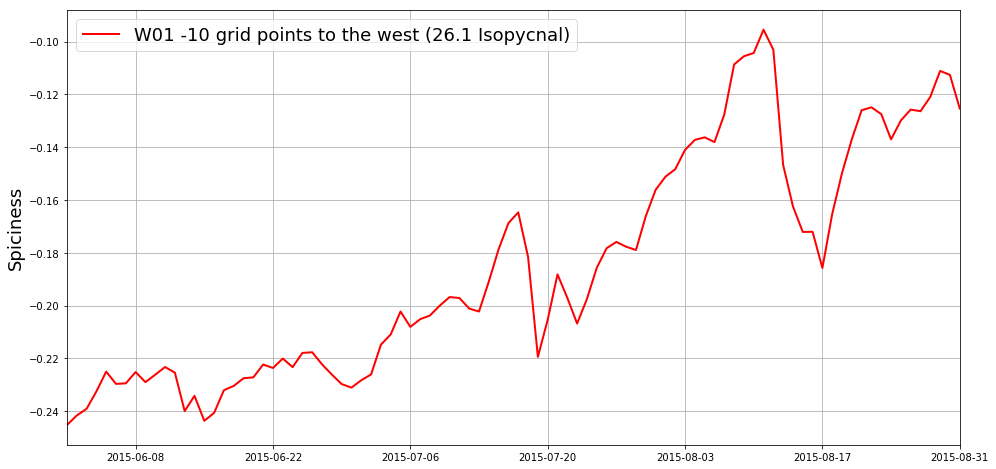

In [115]:
date1 = '2015-06-01'
date2 = '2015-08-31'
mydates = np.array(pd.date_range(date1, date2))
 
# Make plots
fig, (ax) = plt.subplots(1, 1, figsize=(16,8))
ax.plot(mydates , spic_3_months_W02_26_4, 'r-',linewidth=2, label = 'W01 -10 grid points to the west (26.1 Isopycnal)')
# ax.plot(mydates , spic_3_months_A1_26_3, 'b-',linewidth=2, label = 'E01 (26.3 Isopycnal)')
legend = ax.legend(loc='best', fancybox=True, framealpha=0.75, fontsize = 18)
ax.set_ylabel('Spiciness', fontsize =18)
ax.set_xlim(mydates[0],mydates[-1])
#ax.set_xticklabels(date_time[3600:6808])
# ax2.set_ylim(-12,10)
ax.grid() 

